In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
import matplotlib.pyplot as plt
import os
import anndata
import harmonypy as hm
import seaborn as sns
import scrublet as scr
import bbknn as bk
%matplotlib inline

/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.settings.set_figure_params(dpi=250,fontsize=10)

In [4]:
adata = sc.read_h5ad("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Test/Test2_nolog/bin50_D2-3.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 26628 × 96
    obs: 'X_Y_bins', 'X_coor', 'Y_coor'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
adata.obs['arterial_ec'] = (adata.X[:,adata.var_names=='GJA5'] > 1) & (adata.X[:,adata.var_names=='VWF'] > 1)

In [7]:
adata_aec = adata[adata.obs['arterial_ec'] == True]

In [8]:
adata_aec

View of AnnData object with n_obs × n_vars = 190 × 96
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_ec'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [9]:
data = adata_aec.obs[['X_coor','Y_coor']]
linkage_data = linkage(data, method='average', metric='euclidean')

In [10]:
temp = dendrogram(linkage_data,no_plot=True)

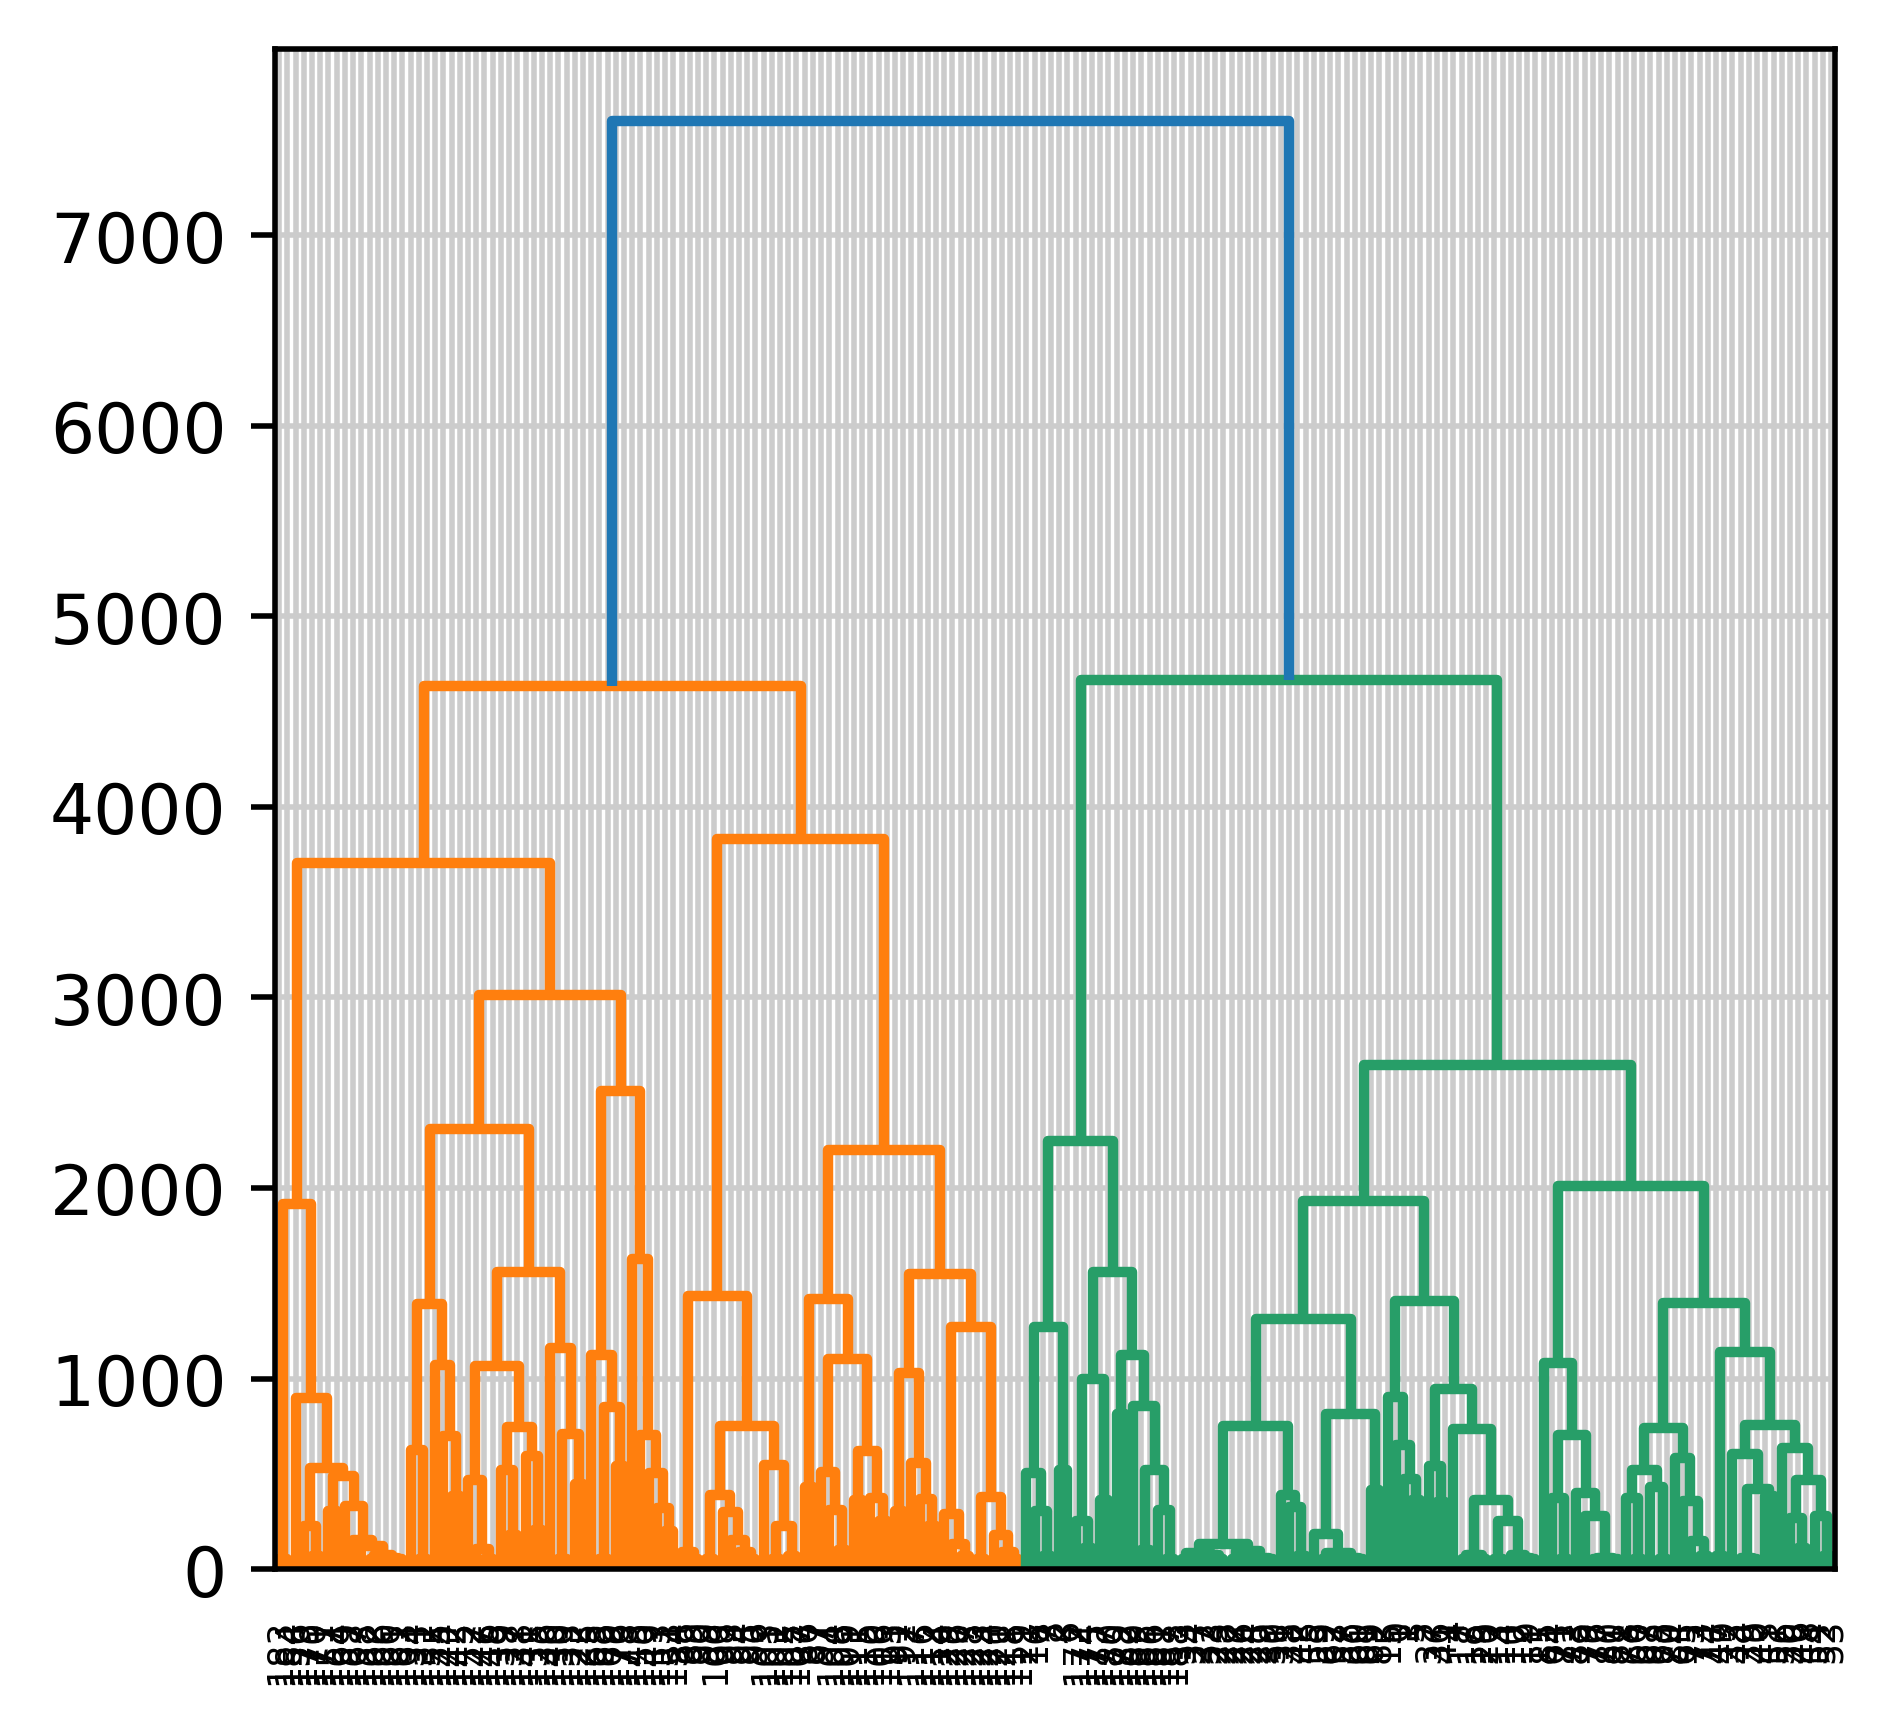

In [11]:
dendrogram(linkage_data)
plt.show()

In [12]:
# adjust n_clusters to relevant number of vessels
hierarchical_cluster = AgglomerativeClustering(n_clusters=120, affinity='euclidean', linkage='single')

In [13]:
labels = hierarchical_cluster.fit_predict(data) 
print(labels)

[ 91 113  87 117  69  79  99   9   9  59  59  59  59  52  52  80 100 106
 106 106 106  95  34  34  34  34  34  34  34  34  34  76  34  34  34  66
  65  63  73  42  42  82  50  86  42  50  10   8  10   8 112  62  12  12
  98   1  32   1   1   1   1   1   1  70 111  64  51  51  20  68  20  18
  18   4   4   4  61  61  78 110  61  61 103  74 105  77 119  60  29  29
  29  38  92   6   6   6   6  84  71  25  25  28  28  93  97   3 108   3
  11  11  67  31  36 107  55  75 102 101   0   0   0   0  48  21  21 115
   2   2   2  94  43  16  16  43  89  88 116 118  72  53  83  45  35 114
  15  17  13  13  13 109  81  54  26  49  58  33  85  46  24 104  24  24
  24  24  90  39  24  24  30  30  27  27  96  56   5   5  57  37  41  47
  40  44  23   7   7  14  14  22  22  19]


/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [14]:
adata_aec.obs['Artery_clusters'] = labels
adata_aec.obs['Artery_clusters'] = adata_aec.obs['Artery_clusters'].astype('category')

/var/tmp/pbs.8217755.pbs/ipykernel_3432969/2590496195.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_aec.obs['Artery_clusters'] = labels
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [15]:
adata_aec.obs['Artery_clusters'].value_counts()

34     12
24      7
1       7
59      4
106     4
       ..
57      1
56      1
55      1
54      1
119     1
Name: Artery_clusters, Length: 120, dtype: int64

In [16]:
# subset for clusters > 5 bins
adata_aec.obs['Artery_clusters'].value_counts()[adata_aec.obs['Artery_clusters'].value_counts() > 5].index.tolist()

[34, 24, 1]

In [17]:
adata_aec_subset = adata_aec[adata_aec.obs.Artery_clusters.isin(adata_aec.obs['Artery_clusters'].value_counts()[adata_aec.obs['Artery_clusters'].value_counts() > 5].index.tolist())]

In [18]:
adata_aec_subset.obs.Artery_clusters = adata_aec_subset.obs.Artery_clusters.astype(str).astype('category')

/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/pandas/core/generic.py:5931: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


In [55]:
## adata_aec

In [56]:
#sc.pl.spatial(adata,color="VWF",img_key='WGA',size=8, alpha_img = 0.2, vmax = 1)

In [57]:
#sc.pl.spatial(adata,color="GJA5",img_key='WGA',size=8, alpha_img = 0.2, vmax = 1)

In [58]:
#del adata_aec.uns['Artery_clusters_colors']
#del adata_aec_subset.uns['Artery_clusters_colors']

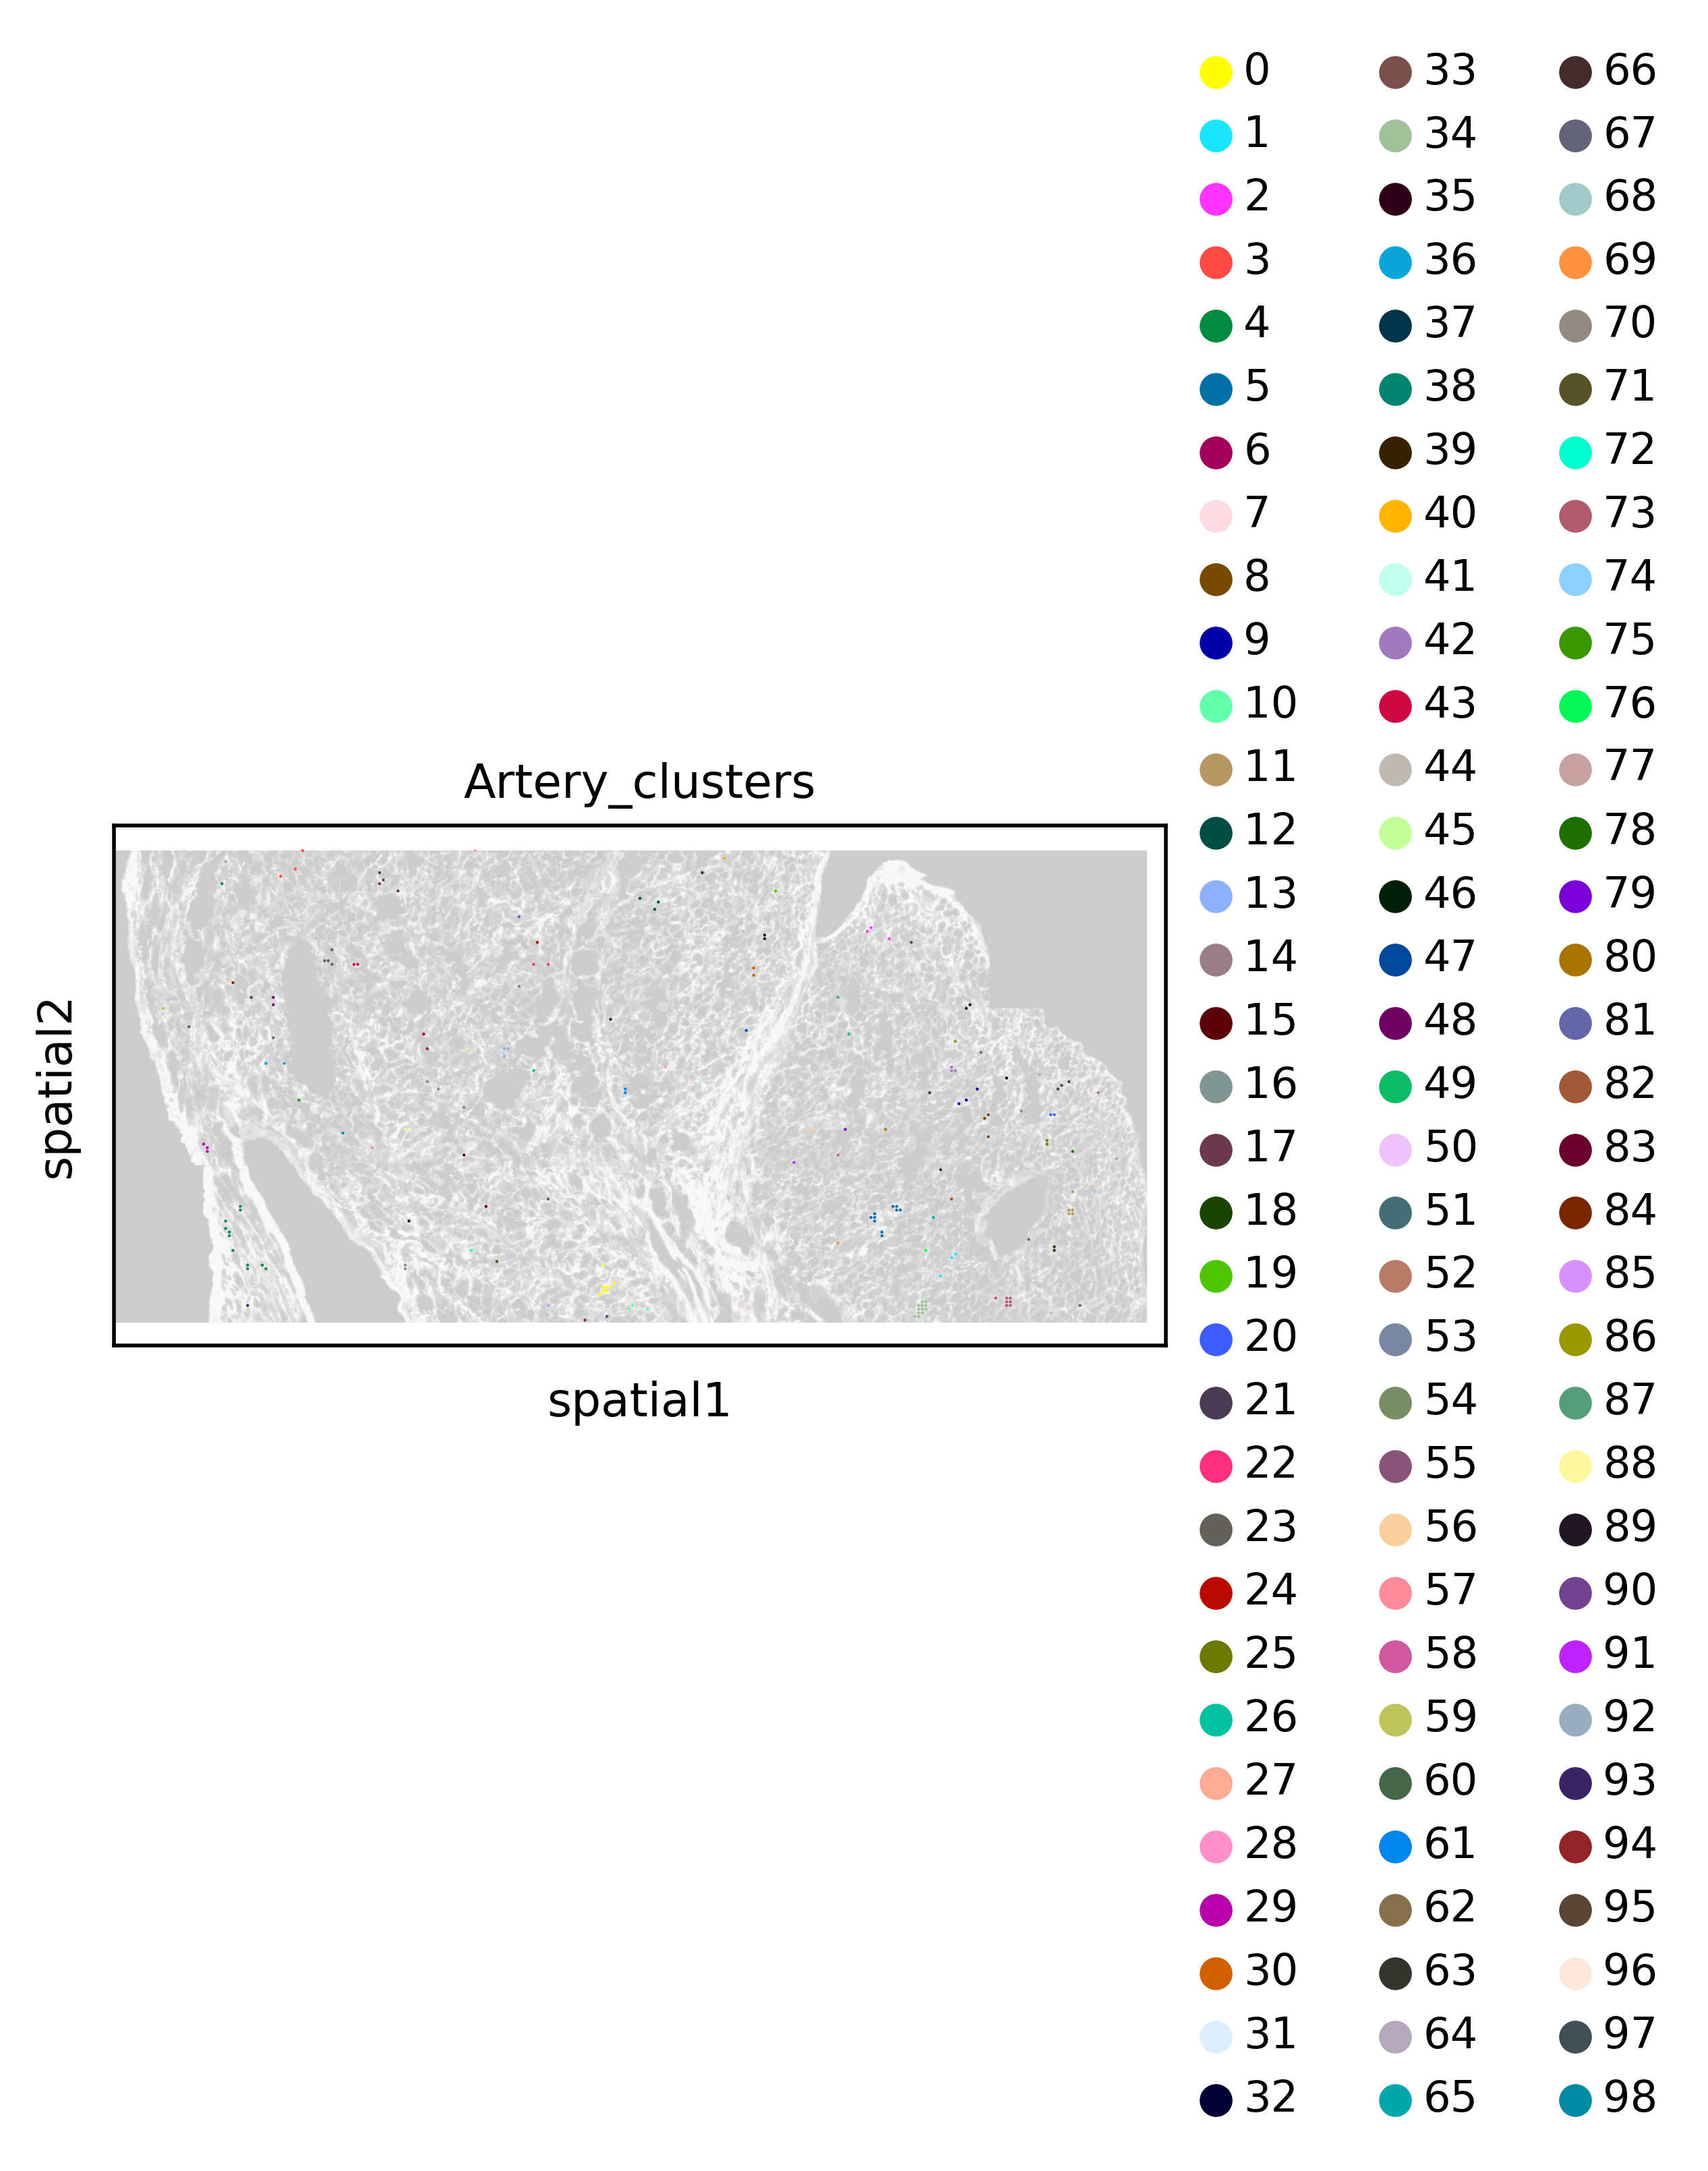

In [59]:
sc.pl.spatial(adata_aec, color="Artery_clusters",img_key='WGA',size=8, alpha_img = 0.2)

In [ ]:
#del adata_aec_subset.uns['Artery_clusters_colors']

In [67]:
adata_aec_subset

AnnData object with n_obs × n_vars = 26 × 96
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_ec', 'Artery_clusters'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

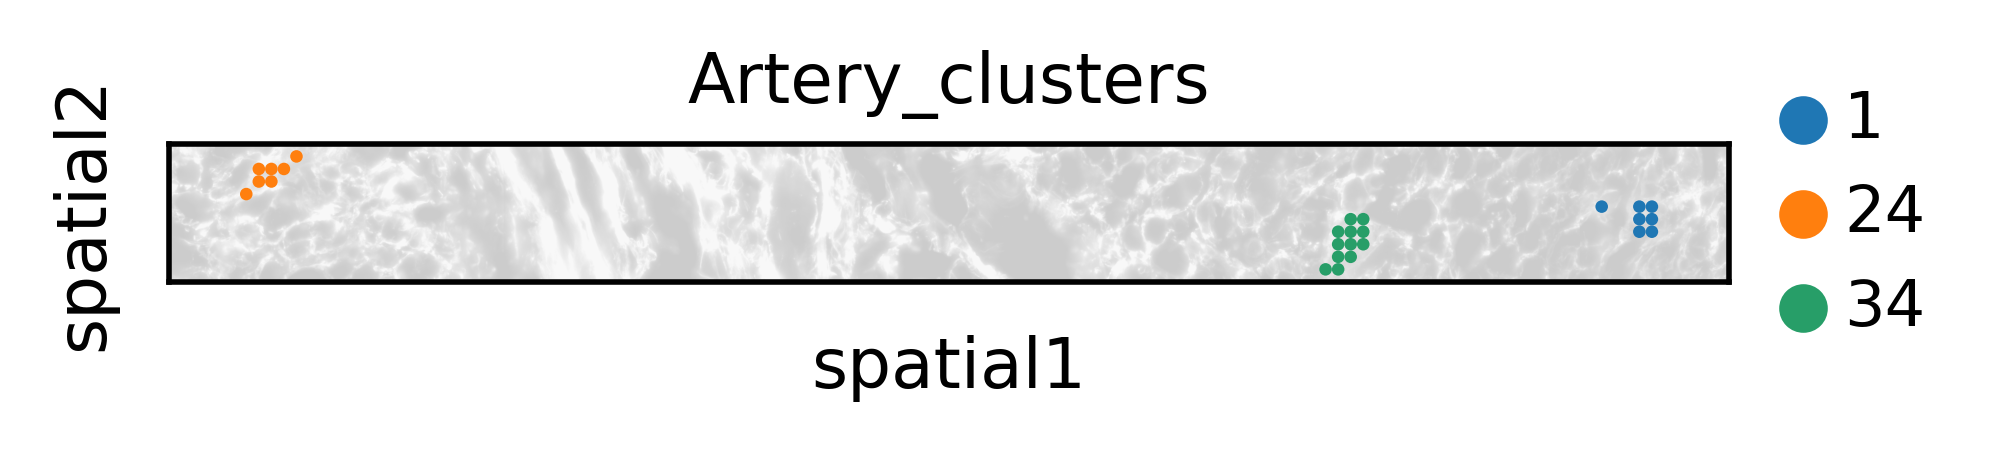

In [68]:
sc.pl.spatial(adata_aec_subset,
              color="Artery_clusters",img_key='WGA',size=10, alpha_img = 0.2)

In [ ]:
#sc.pl.spatial(adata_aec_subset, color="Artery_clusters", groups = ["6","1","12","25","2","13"] ,img_key='WGA',size=10, alpha_img = 0.2)

In [ ]:
sc.pl.spatial(adata_aec, color="MYH11",img_key='WGA',size=10, alpha_img = 1, cmap = 'plasma_r')

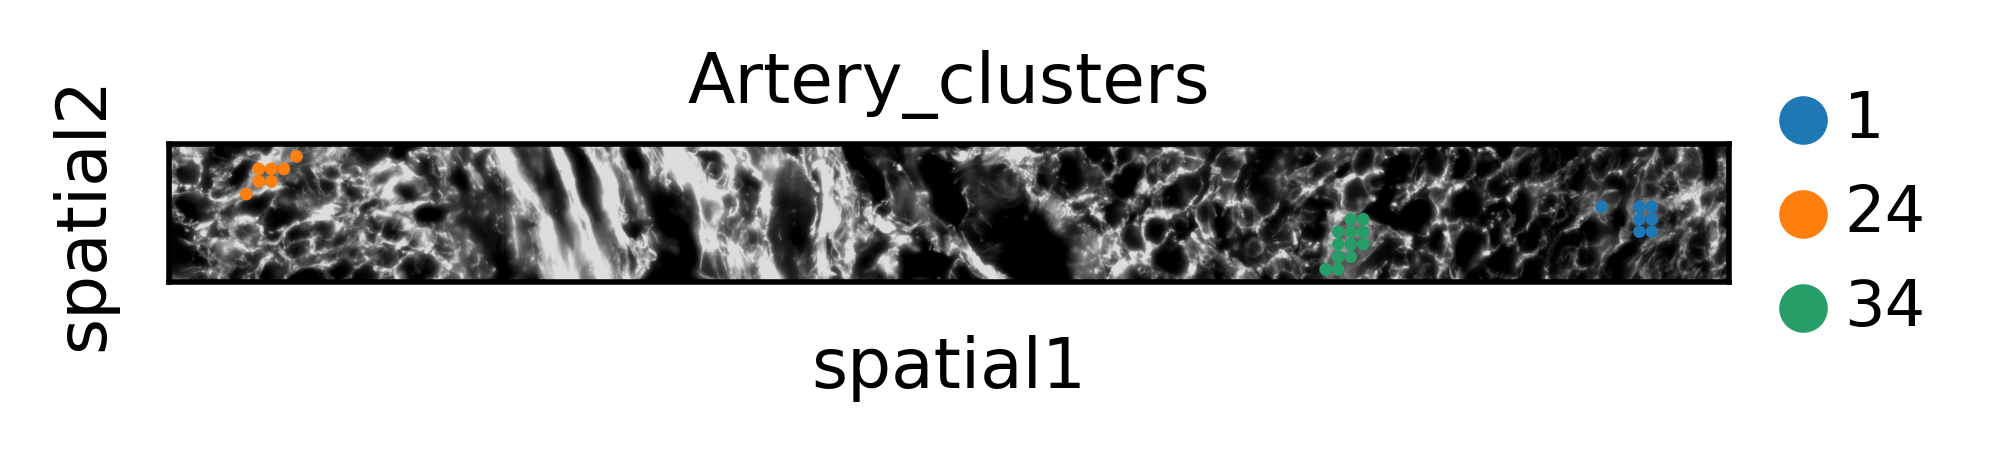

In [69]:
sc.pl.spatial(adata_aec_subset, color="Artery_clusters",img_key='WGA',size=10, alpha_img = 1)

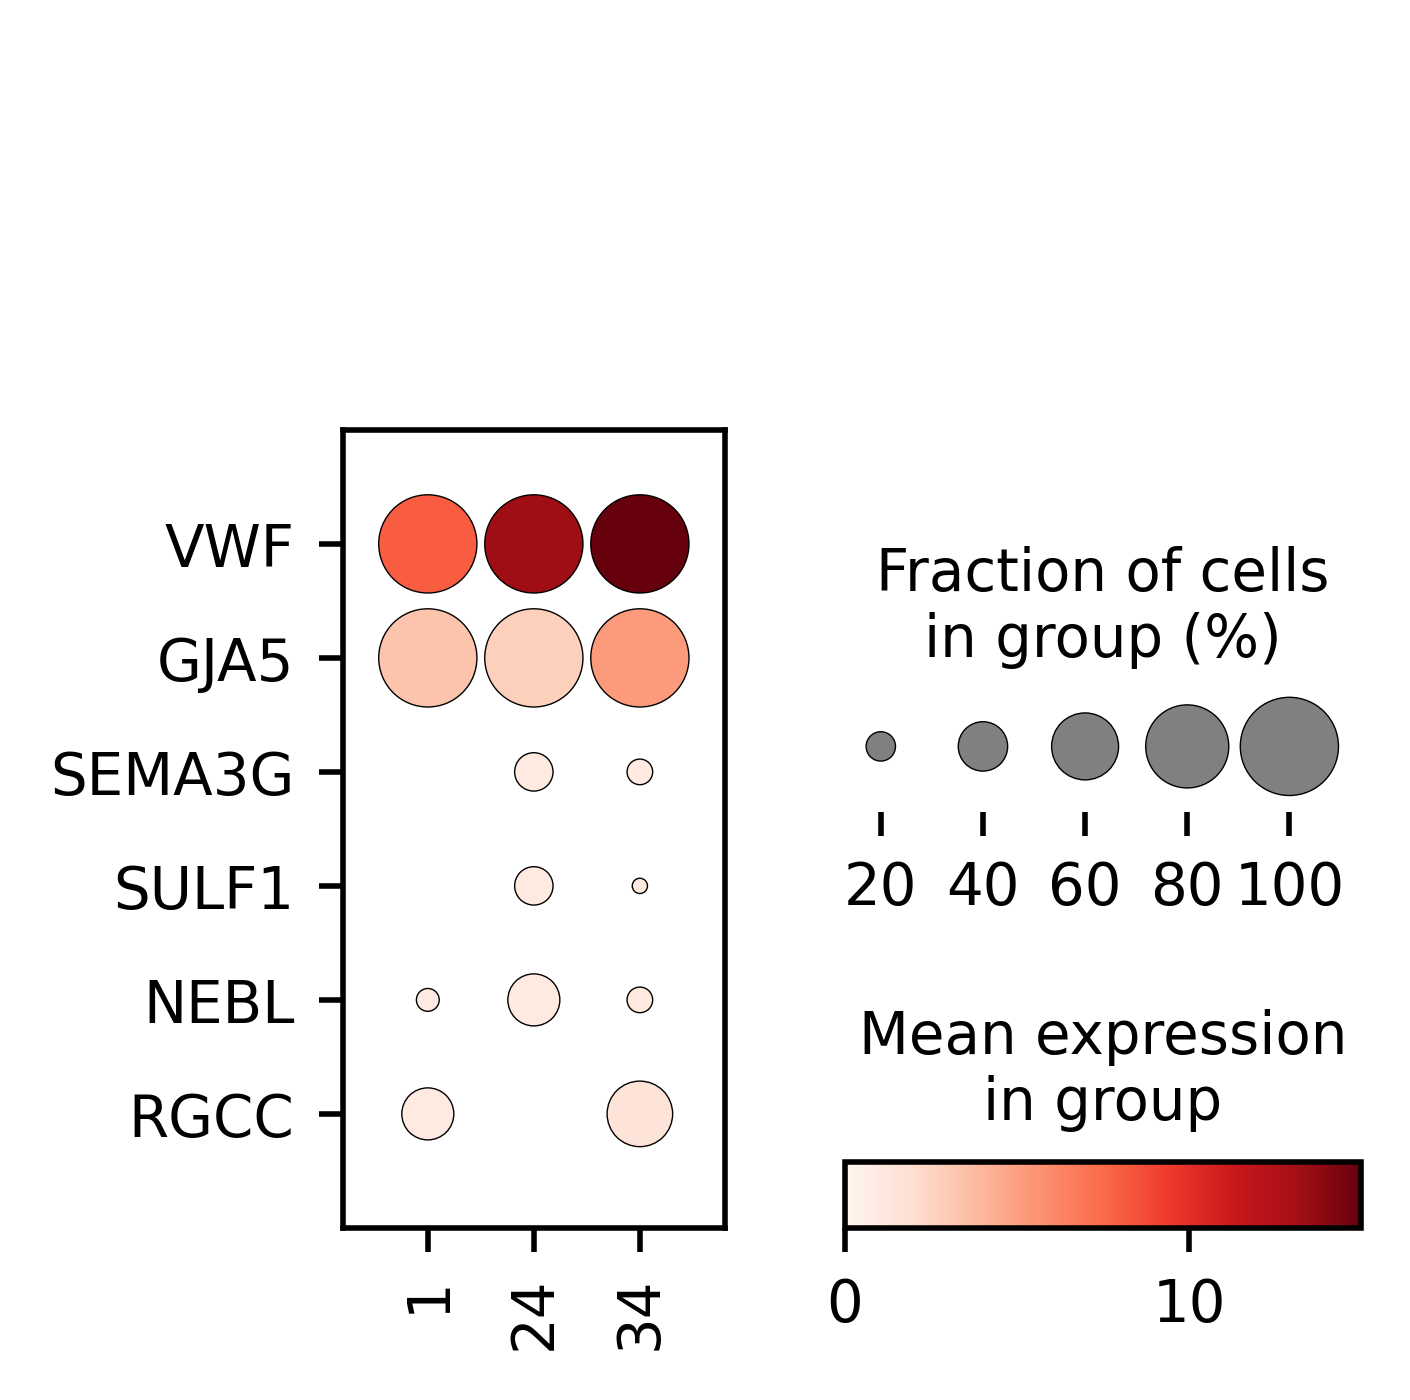

In [70]:
markers = ["VWF","GJA5","SEMA3G","SULF1","NEBL","RGCC"]
sc.pl.dotplot(adata_aec_subset, markers, "Artery_clusters", mean_only_expressed = True, swap_axes = True)
#sc.pl.dotplot(adata_aec_subset, markers, "Artery_clusters", mean_only_expressed = False)

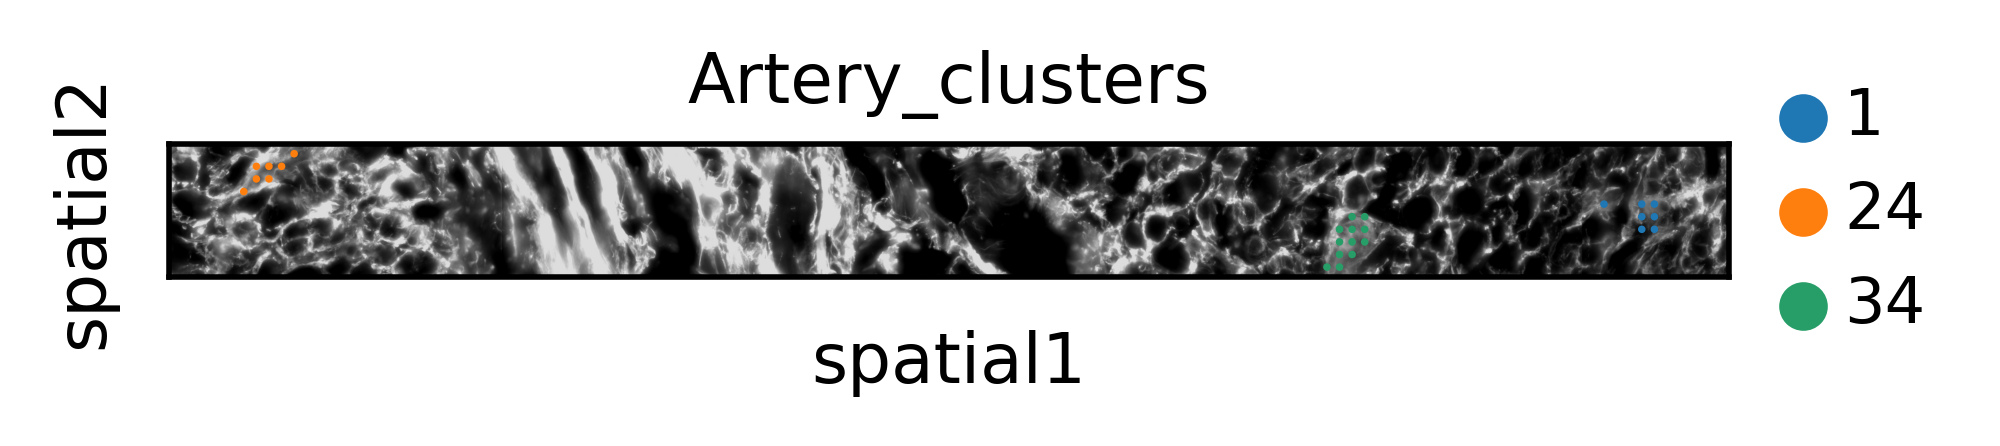

In [71]:
sc.pl.spatial(adata_aec_subset,
              color="Artery_clusters",img_key='WGA',size=6)

### obtain bins percent expressing values

In [19]:
adata_aec_subset.obs['SULF1_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='SULF1'] > 1)

In [20]:
adata_aec_subset.obs['NEBL_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='NEBL'] > 1)

In [21]:
adata_aec_subset.obs['SEMA3G_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='SEMA3G'] > 0)

In [22]:
adata_aec_subset.obs['RGCC_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='RGCC'] > 0)

In [23]:
adata_aec_subset.obs['SULF1+NEBL_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='SULF1'] > 1) & (adata_aec_subset.X[:,adata_aec_subset.var_names=='NEBL'] > 1)

In [24]:
adata_aec_subset

AnnData object with n_obs × n_vars = 26 × 96
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_ec', 'Artery_clusters', 'SULF1_percent', 'NEBL_percent', 'SEMA3G_percent', 'RGCC_percent', 'SULF1+NEBL_percent'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [25]:
results = adata_aec_subset.obs[['SULF1+NEBL_percent','SULF1_percent','NEBL_percent','SEMA3G_percent','RGCC_percent','Artery_clusters']].groupby('Artery_clusters').mean()

In [26]:
results

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent
Artery_clusters,,,,,
1,0.0,0.0,0.0,0.000000,0.428571
24,0.0,0.0,0.0,0.285714,0.000000
34,0.0,0.0,0.0,0.166667,0.583333


### obtain mean expression (all bins / cluster)

In [27]:
matrix=pd.DataFrame(adata_aec_subset.X,columns=adata_aec_subset.raw.var.index,index=adata_aec_subset.obs.index)

In [28]:
matrix["Artery_clusters"] = adata_aec_subset.obs["Artery_clusters"]

In [29]:
df_mean=matrix.groupby("Artery_clusters").mean()

In [30]:
df_mean[["SULF1","NEBL","SEMA3G","RGCC"]]

Genes,SULF1,NEBL,SEMA3G,RGCC
Artery_clusters,,,,
1,0.000000,0.142857,0.000000,0.428571
24,0.285714,0.428571,0.285714,0.000000
34,0.083333,0.166667,0.166667,0.916667


### obtain mean expression (expressing bins only / cluster)

In [31]:
matrix2 = matrix.replace(0, np.NaN)

In [32]:
df_mean_nonzero =matrix2.groupby("Artery_clusters").mean()

In [33]:
df_mean_nonzero[["SULF1","NEBL","SEMA3G","RGCC"]]

Genes,SULF1,NEBL,SEMA3G,RGCC
Artery_clusters,,,,
1,NaN,1.0,NaN,1.000000
24,1.0,1.0,1.0,NaN
34,1.0,1.0,1.0,1.571429


### add expression values to dataframe

In [34]:
#mean expression (all bins / cluster)
test = pd.concat([results, df_mean[["SULF1","NEBL","SEMA3G","RGCC"]]], axis = 1)

In [35]:
test

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent,SULF1,NEBL,SEMA3G,RGCC
Artery_clusters,,,,,,,,,
1,0.0,0.0,0.0,0.000000,0.428571,0.000000,0.142857,0.000000,0.428571
24,0.0,0.0,0.0,0.285714,0.000000,0.285714,0.428571,0.285714,0.000000
34,0.0,0.0,0.0,0.166667,0.583333,0.083333,0.166667,0.166667,0.916667


In [36]:
#mean expression (expressing bins only / cluster)
test2 = pd.concat([results, df_mean_nonzero[["SULF1","NEBL","SEMA3G","RGCC"]]], axis = 1)

In [37]:
test2

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent,SULF1,NEBL,SEMA3G,RGCC
Artery_clusters,,,,,,,,,
1,0.0,0.0,0.0,0.000000,0.428571,NaN,1.0,NaN,1.000000
24,0.0,0.0,0.0,0.285714,0.000000,1.0,1.0,1.0,NaN
34,0.0,0.0,0.0,0.166667,0.583333,1.0,1.0,1.0,1.571429


In [38]:
test2.rename(columns={"SULF1": "SULF1_mean", "NEBL": "NEBL_mean", "SEMA3G": "SEMA3G_mean", "RGCC": "RGCC_mean"}, inplace = True)

In [39]:
test2

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent,SULF1_mean,NEBL_mean,SEMA3G_mean,RGCC_mean
Artery_clusters,,,,,,,,,
1,0.0,0.0,0.0,0.000000,0.428571,NaN,1.0,NaN,1.000000
24,0.0,0.0,0.0,0.285714,0.000000,1.0,1.0,1.0,NaN
34,0.0,0.0,0.0,0.166667,0.583333,1.0,1.0,1.0,1.571429


## add raw values

In [40]:
df_sum=matrix.groupby("Artery_clusters").sum()

In [41]:
df_sum[["SULF1","NEBL","SEMA3G","RGCC","GJA5"]]

Genes,SULF1,NEBL,SEMA3G,RGCC,GJA5
Artery_clusters,,,,,
1,0.0,1.0,0.0,3.0,23.0
24,2.0,3.0,2.0,0.0,19.0
34,1.0,2.0,2.0,11.0,63.0


In [42]:
test3 = pd.concat([test2, df_sum[["SULF1","NEBL","SEMA3G","RGCC"]]], axis = 1)

In [43]:
test3

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent,SULF1_mean,NEBL_mean,SEMA3G_mean,RGCC_mean,SULF1,NEBL,SEMA3G,RGCC
Artery_clusters,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.000000,0.428571,NaN,1.0,NaN,1.000000,0.0,1.0,0.0,3.0
24,0.0,0.0,0.0,0.285714,0.000000,1.0,1.0,1.0,NaN,2.0,3.0,2.0,0.0
34,0.0,0.0,0.0,0.166667,0.583333,1.0,1.0,1.0,1.571429,1.0,2.0,2.0,11.0


### add cluster size (no. bins / vessel)

In [44]:
results2 = test3.join(adata_aec_subset.obs['Artery_clusters'].value_counts(), on=None, how='left', lsuffix='', rsuffix='', sort=False, validate=None)

In [45]:
results2.columns = list(results2.columns[0:13]) + ['size']

In [46]:
results2

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent,SULF1_mean,NEBL_mean,SEMA3G_mean,RGCC_mean,SULF1,NEBL,SEMA3G,RGCC,size
Artery_clusters,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.000000,0.428571,NaN,1.0,NaN,1.000000,0.0,1.0,0.0,3.0,7
24,0.0,0.0,0.0,0.285714,0.000000,1.0,1.0,1.0,NaN,2.0,3.0,2.0,0.0,7
34,0.0,0.0,0.0,0.166667,0.583333,1.0,1.0,1.0,1.571429,1.0,2.0,2.0,11.0,12


### add ROI numbers

In [47]:
results2.index = ['ROI_D2-3_' + str(i) for i in results2.index.tolist()]

In [48]:
results2

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent,SULF1_mean,NEBL_mean,SEMA3G_mean,RGCC_mean,SULF1,NEBL,SEMA3G,RGCC,size
ROI_D2-3_1,0.0,0.0,0.0,0.000000,0.428571,NaN,1.0,NaN,1.000000,0.0,1.0,0.0,3.0,7
ROI_D2-3_24,0.0,0.0,0.0,0.285714,0.000000,1.0,1.0,1.0,NaN,2.0,3.0,2.0,0.0,7
ROI_D2-3_34,0.0,0.0,0.0,0.166667,0.583333,1.0,1.0,1.0,1.571429,1.0,2.0,2.0,11.0,12


In [49]:
results2["ROI"] = "D2-3"

In [50]:
results2

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SEMA3G_percent,RGCC_percent,SULF1_mean,NEBL_mean,SEMA3G_mean,RGCC_mean,SULF1,NEBL,SEMA3G,RGCC,size,ROI
ROI_D2-3_1,0.0,0.0,0.0,0.000000,0.428571,NaN,1.0,NaN,1.000000,0.0,1.0,0.0,3.0,7,D2-3
ROI_D2-3_24,0.0,0.0,0.0,0.285714,0.000000,1.0,1.0,1.0,NaN,2.0,3.0,2.0,0.0,7,D2-3
ROI_D2-3_34,0.0,0.0,0.0,0.166667,0.583333,1.0,1.0,1.0,1.571429,1.0,2.0,2.0,11.0,12,D2-3


In [51]:
results2.to_csv("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Arterial_quantification/ROI_df/D2-3.csv")

### define size group (small / large)

In [ ]:
# remove undesired vessels here (i.e. at edge of frame)

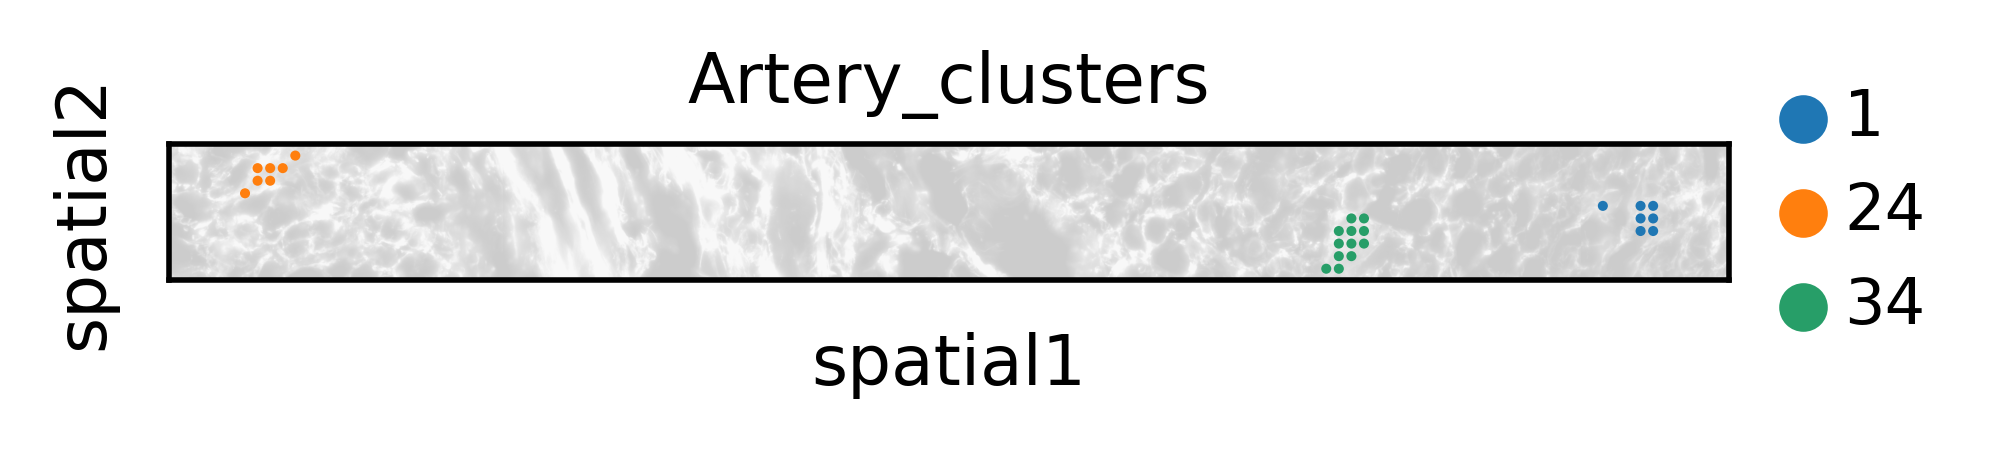

In [96]:
sc.pl.spatial(adata_aec_subset,color="Artery_clusters",img_key='WGA',size=8, alpha_img = 0.2)

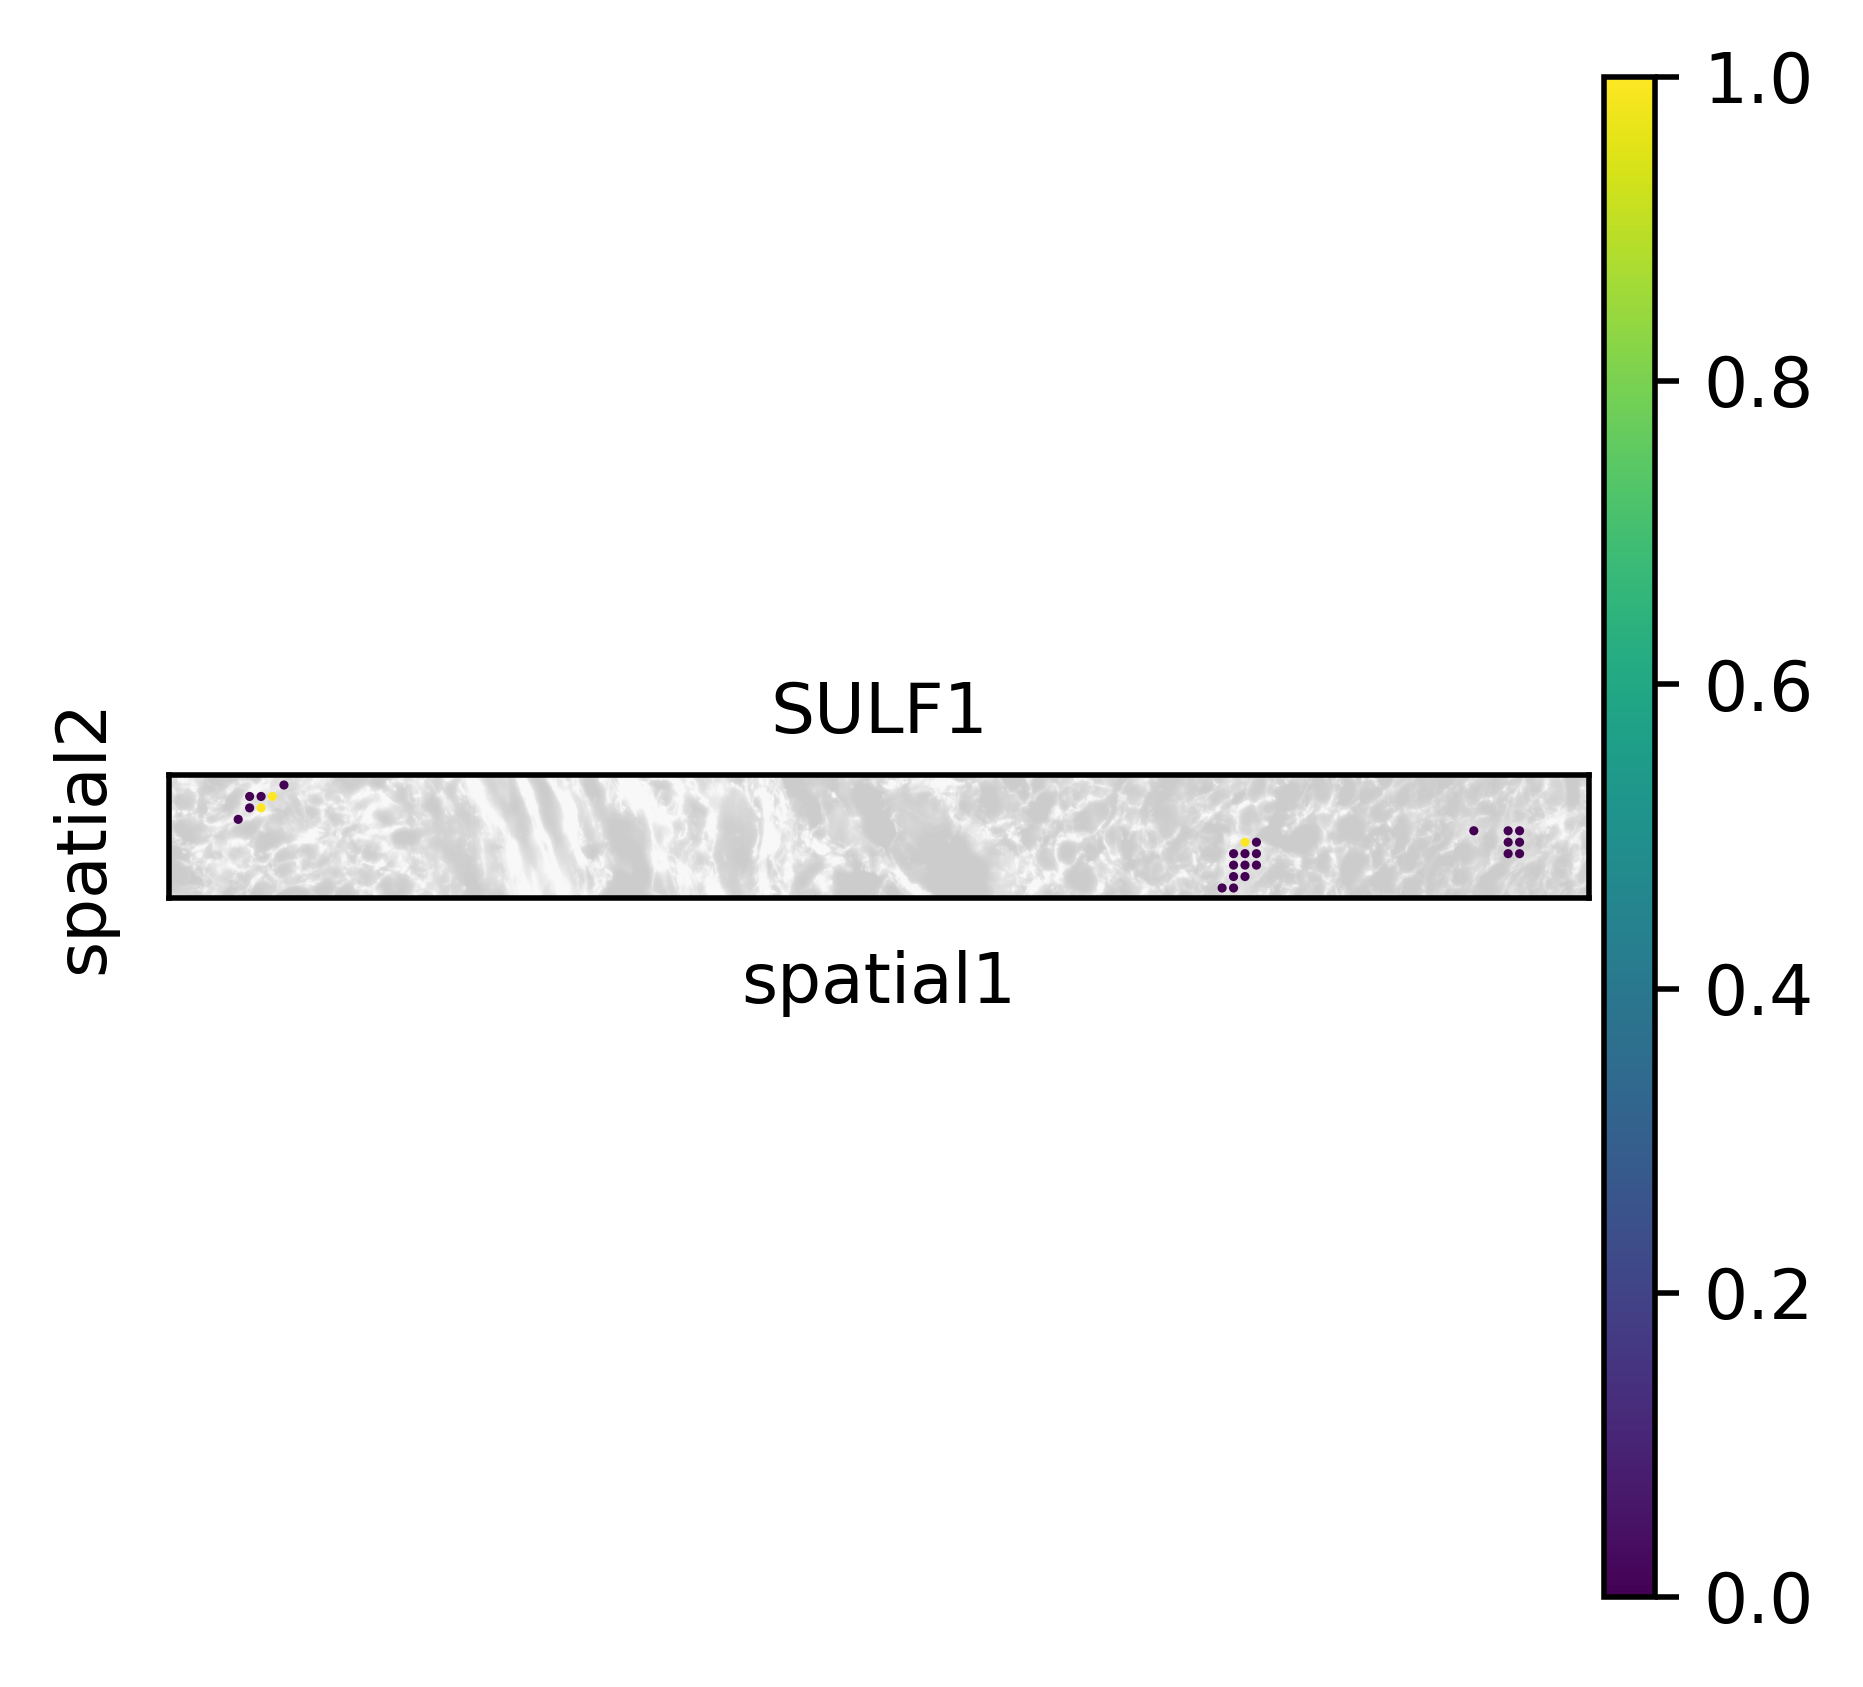

In [97]:
sc.pl.spatial(adata_aec_subset,color="SULF1",img_key='WGA',size=8, alpha_img = 0.2, vmax = 1)

In [98]:
group=pd.Series("Large", index=results2.index)

In [99]:
group[results2["size"] <= 30] = "Small"

In [100]:
group

ROI_D2-3_1     Small
ROI_D2-3_24    Small
ROI_D2-3_34    Small
dtype: object

In [101]:
results2["group"] = group

In [102]:
results2

,SULF1+NEBL_percent,SULF1_percent,NEBL_percent,SULF1,NEBL,SEMA3G,RGCC,size,ROI,group
ROI_D2-3_1,0.0,0.0,0.0,NaN,1.0,NaN,1.000000,7,D2-3,Small
ROI_D2-3_24,0.0,0.0,0.0,1.0,1.0,1.0,NaN,7,D2-3,Small
ROI_D2-3_34,0.0,0.0,0.0,1.0,1.0,1.0,1.571429,12,D2-3,Small


In [ ]:
#results4 = results2.drop(["ROI_D2-1_x"])
#results4

In [112]:
results2.to_csv("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Arterial_quantification/D2-3.csv")

[Text(0.5, 1.0, 'SULF1 mean expression')]

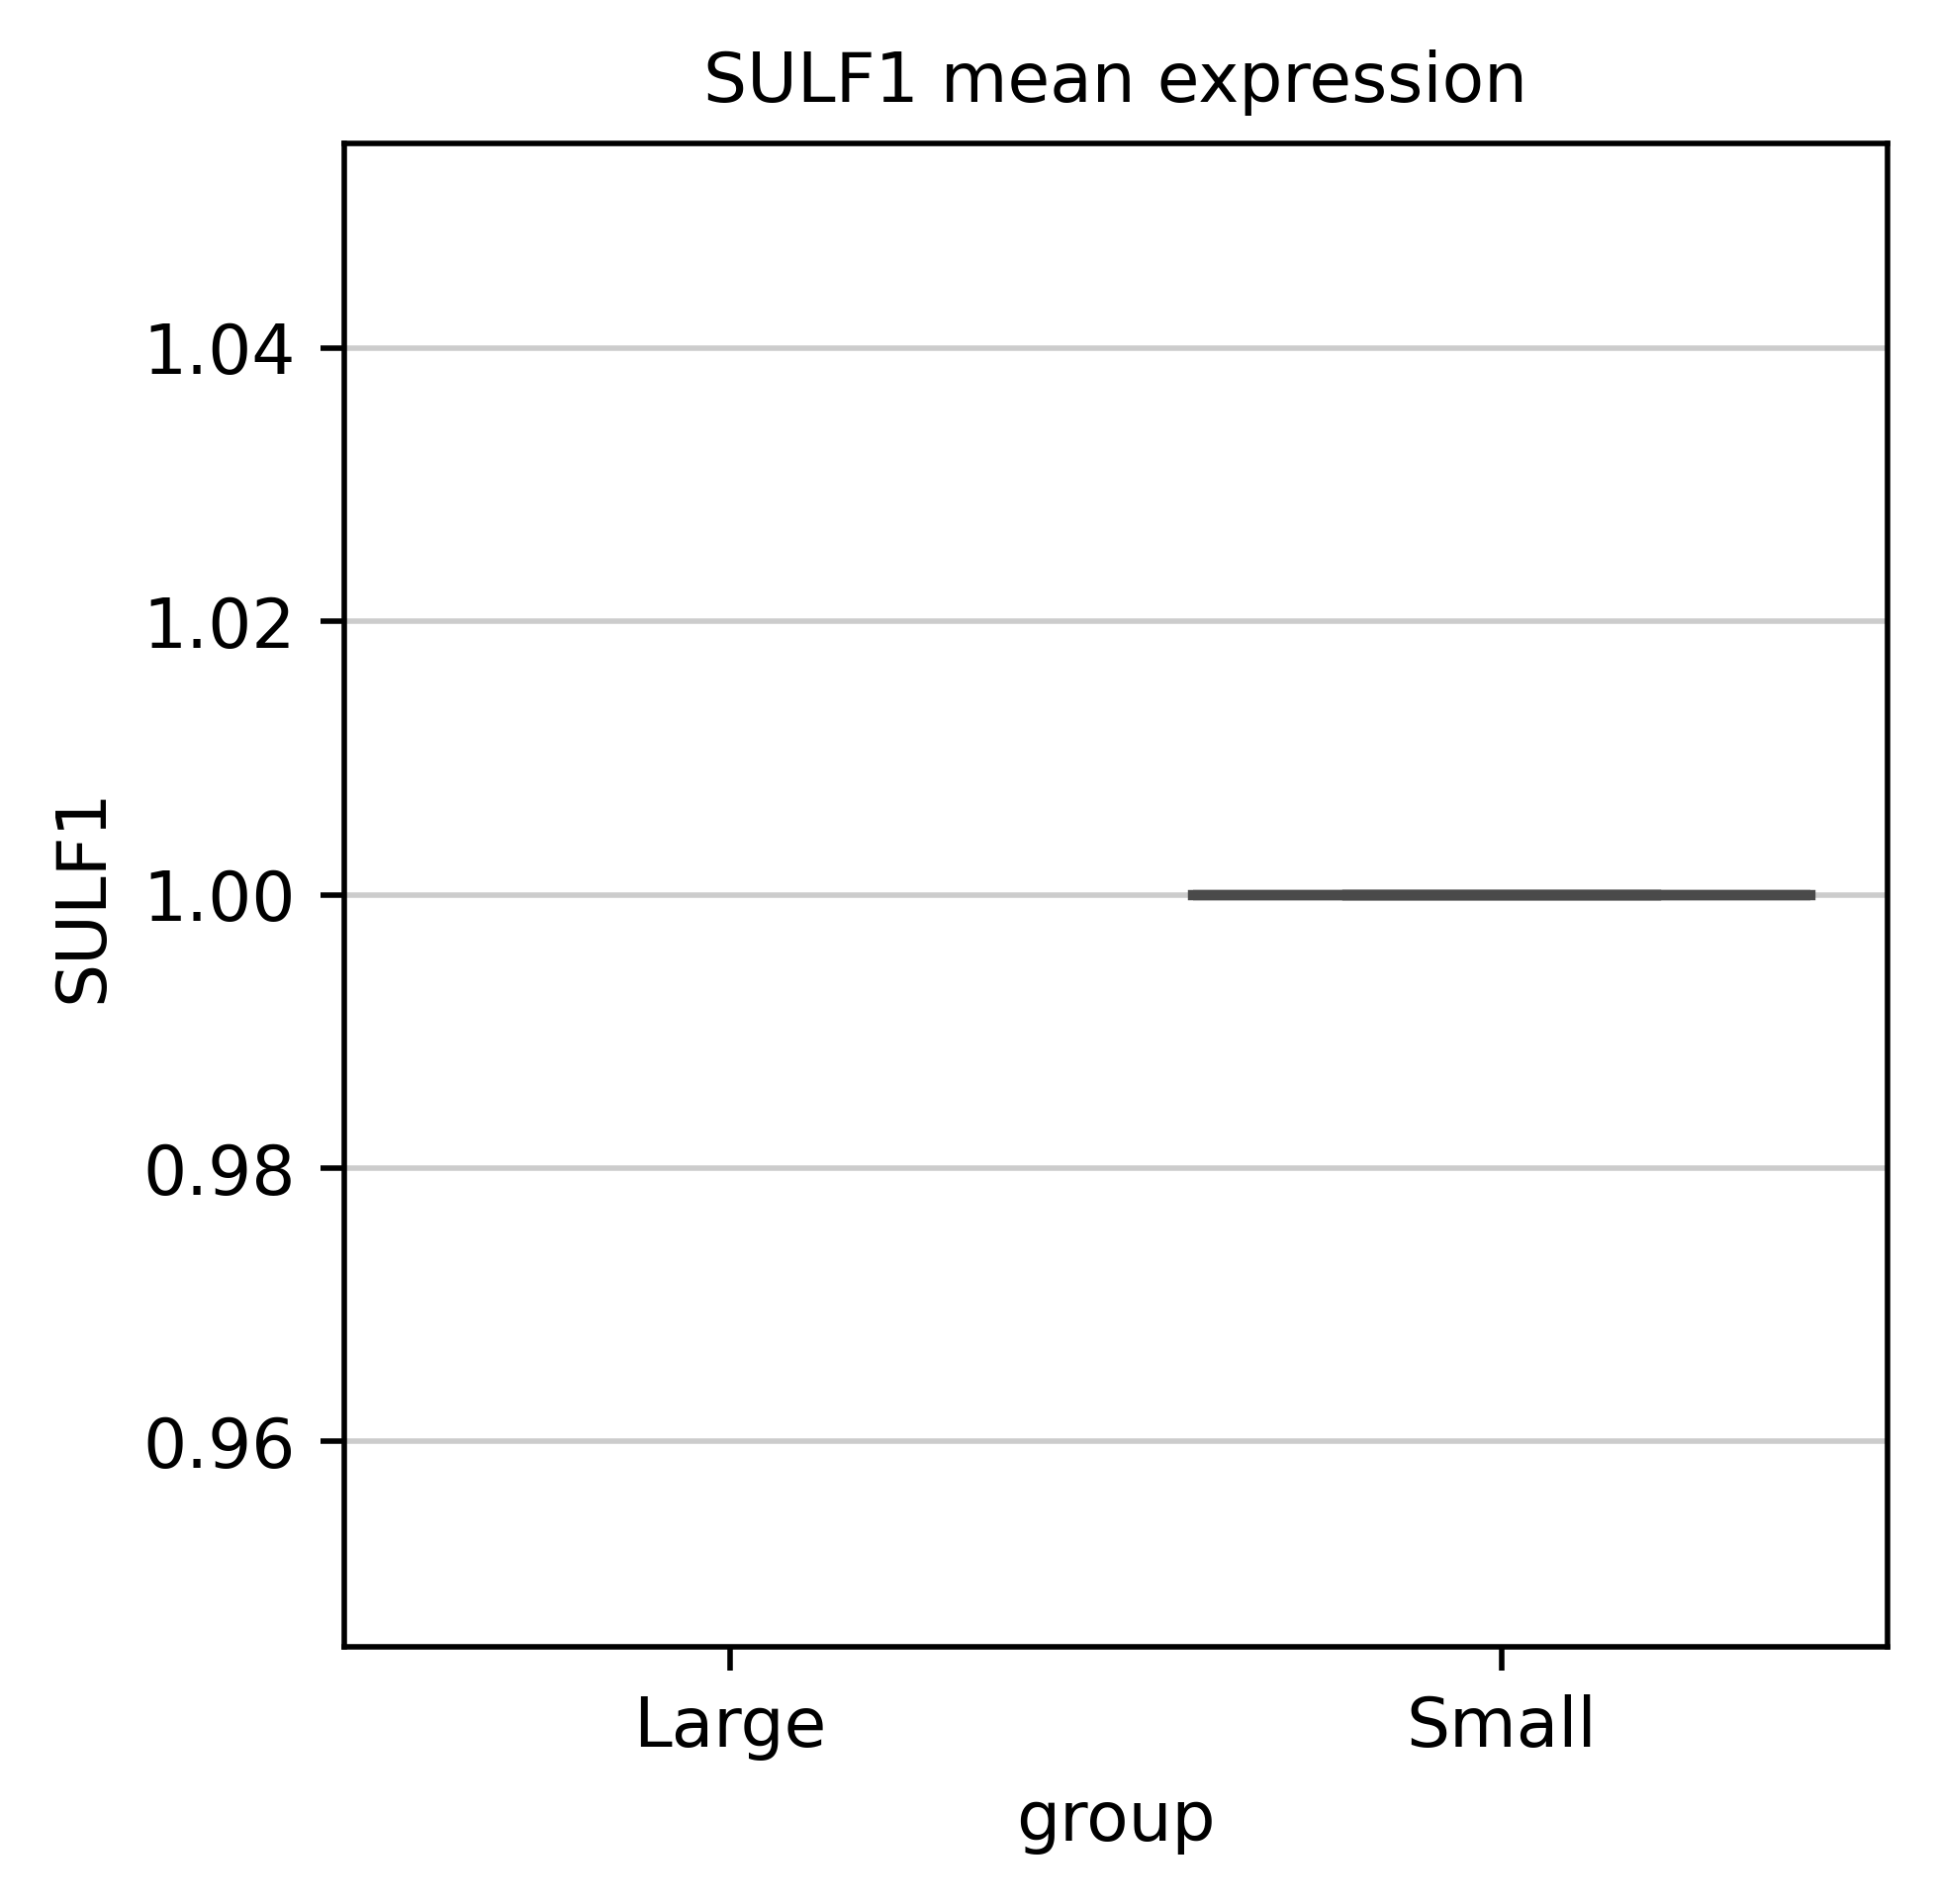

In [104]:
sns.boxplot(data = results2, x = "group", y = "SULF1", palette = 'Blues', order = ['Large','Small']).set(title='SULF1 mean expression')

[Text(0.5, 1.0, 'SULF1 percent expressing')]

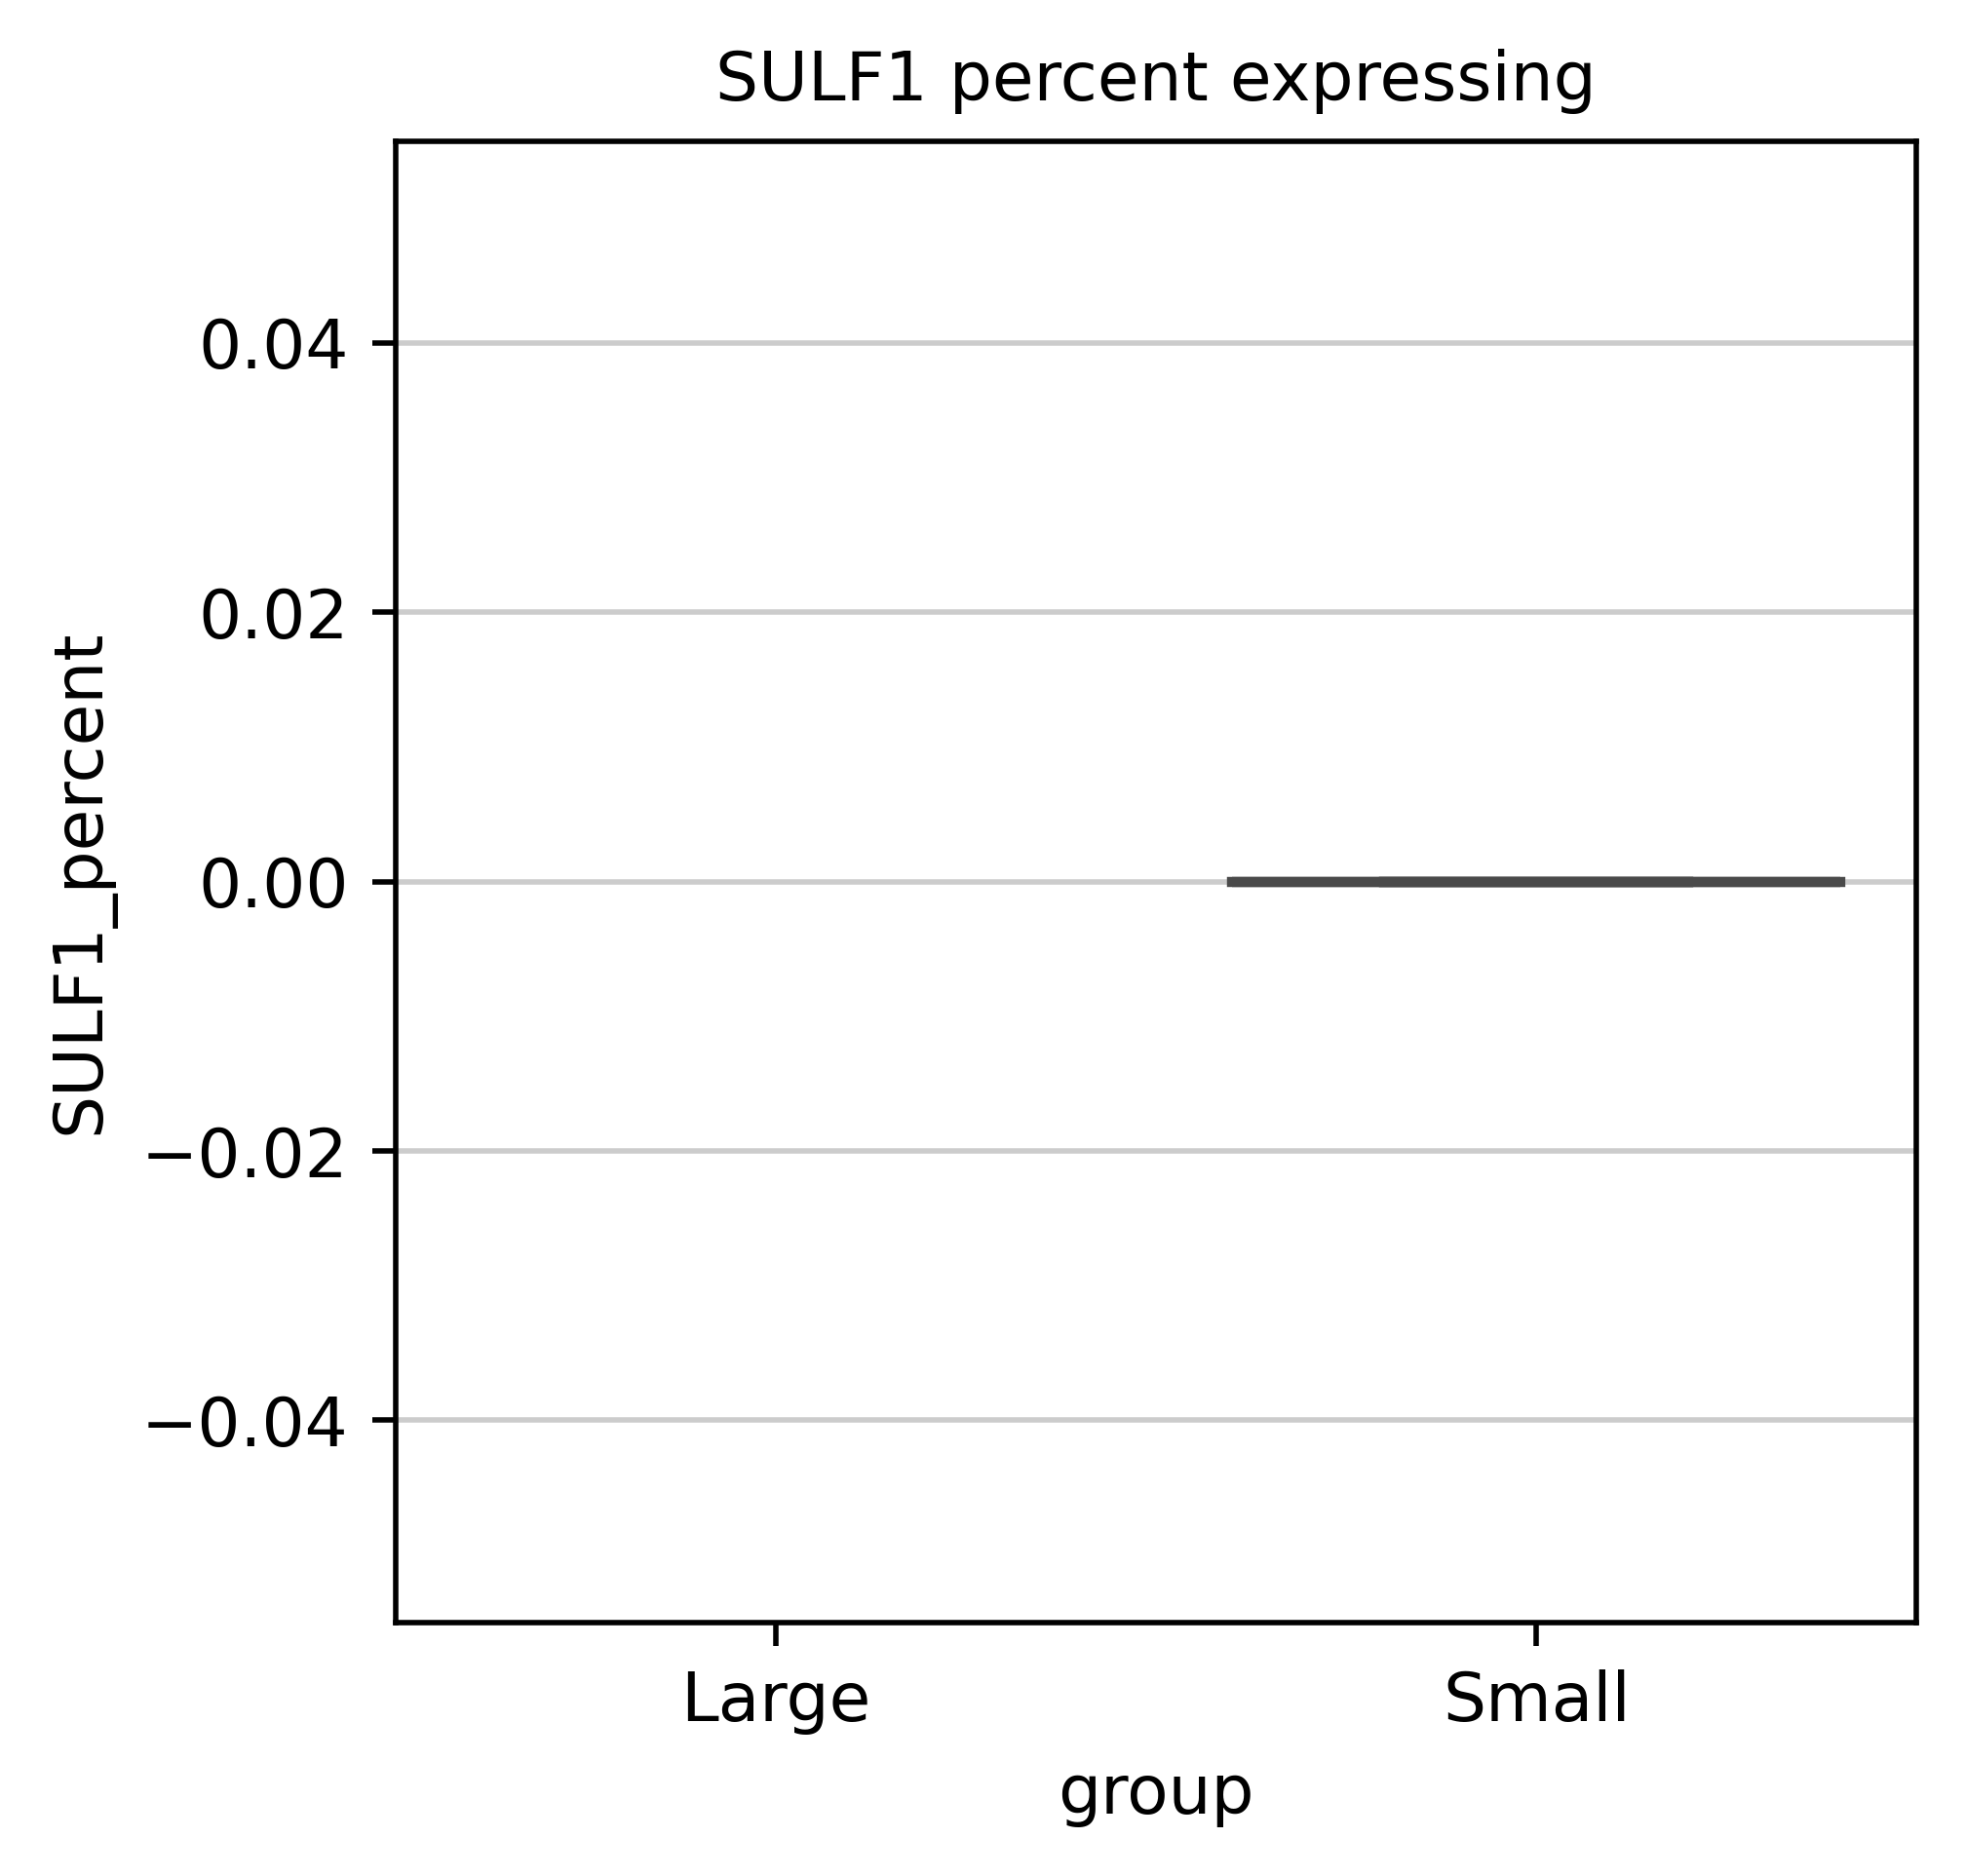

In [105]:
sns.boxplot(data = results2, x = "group", y = "SULF1_percent", palette = 'Blues', order = ['Large','Small']).set(title='SULF1 percent expressing')

[Text(0.5, 1.0, 'RGCC mean expression')]

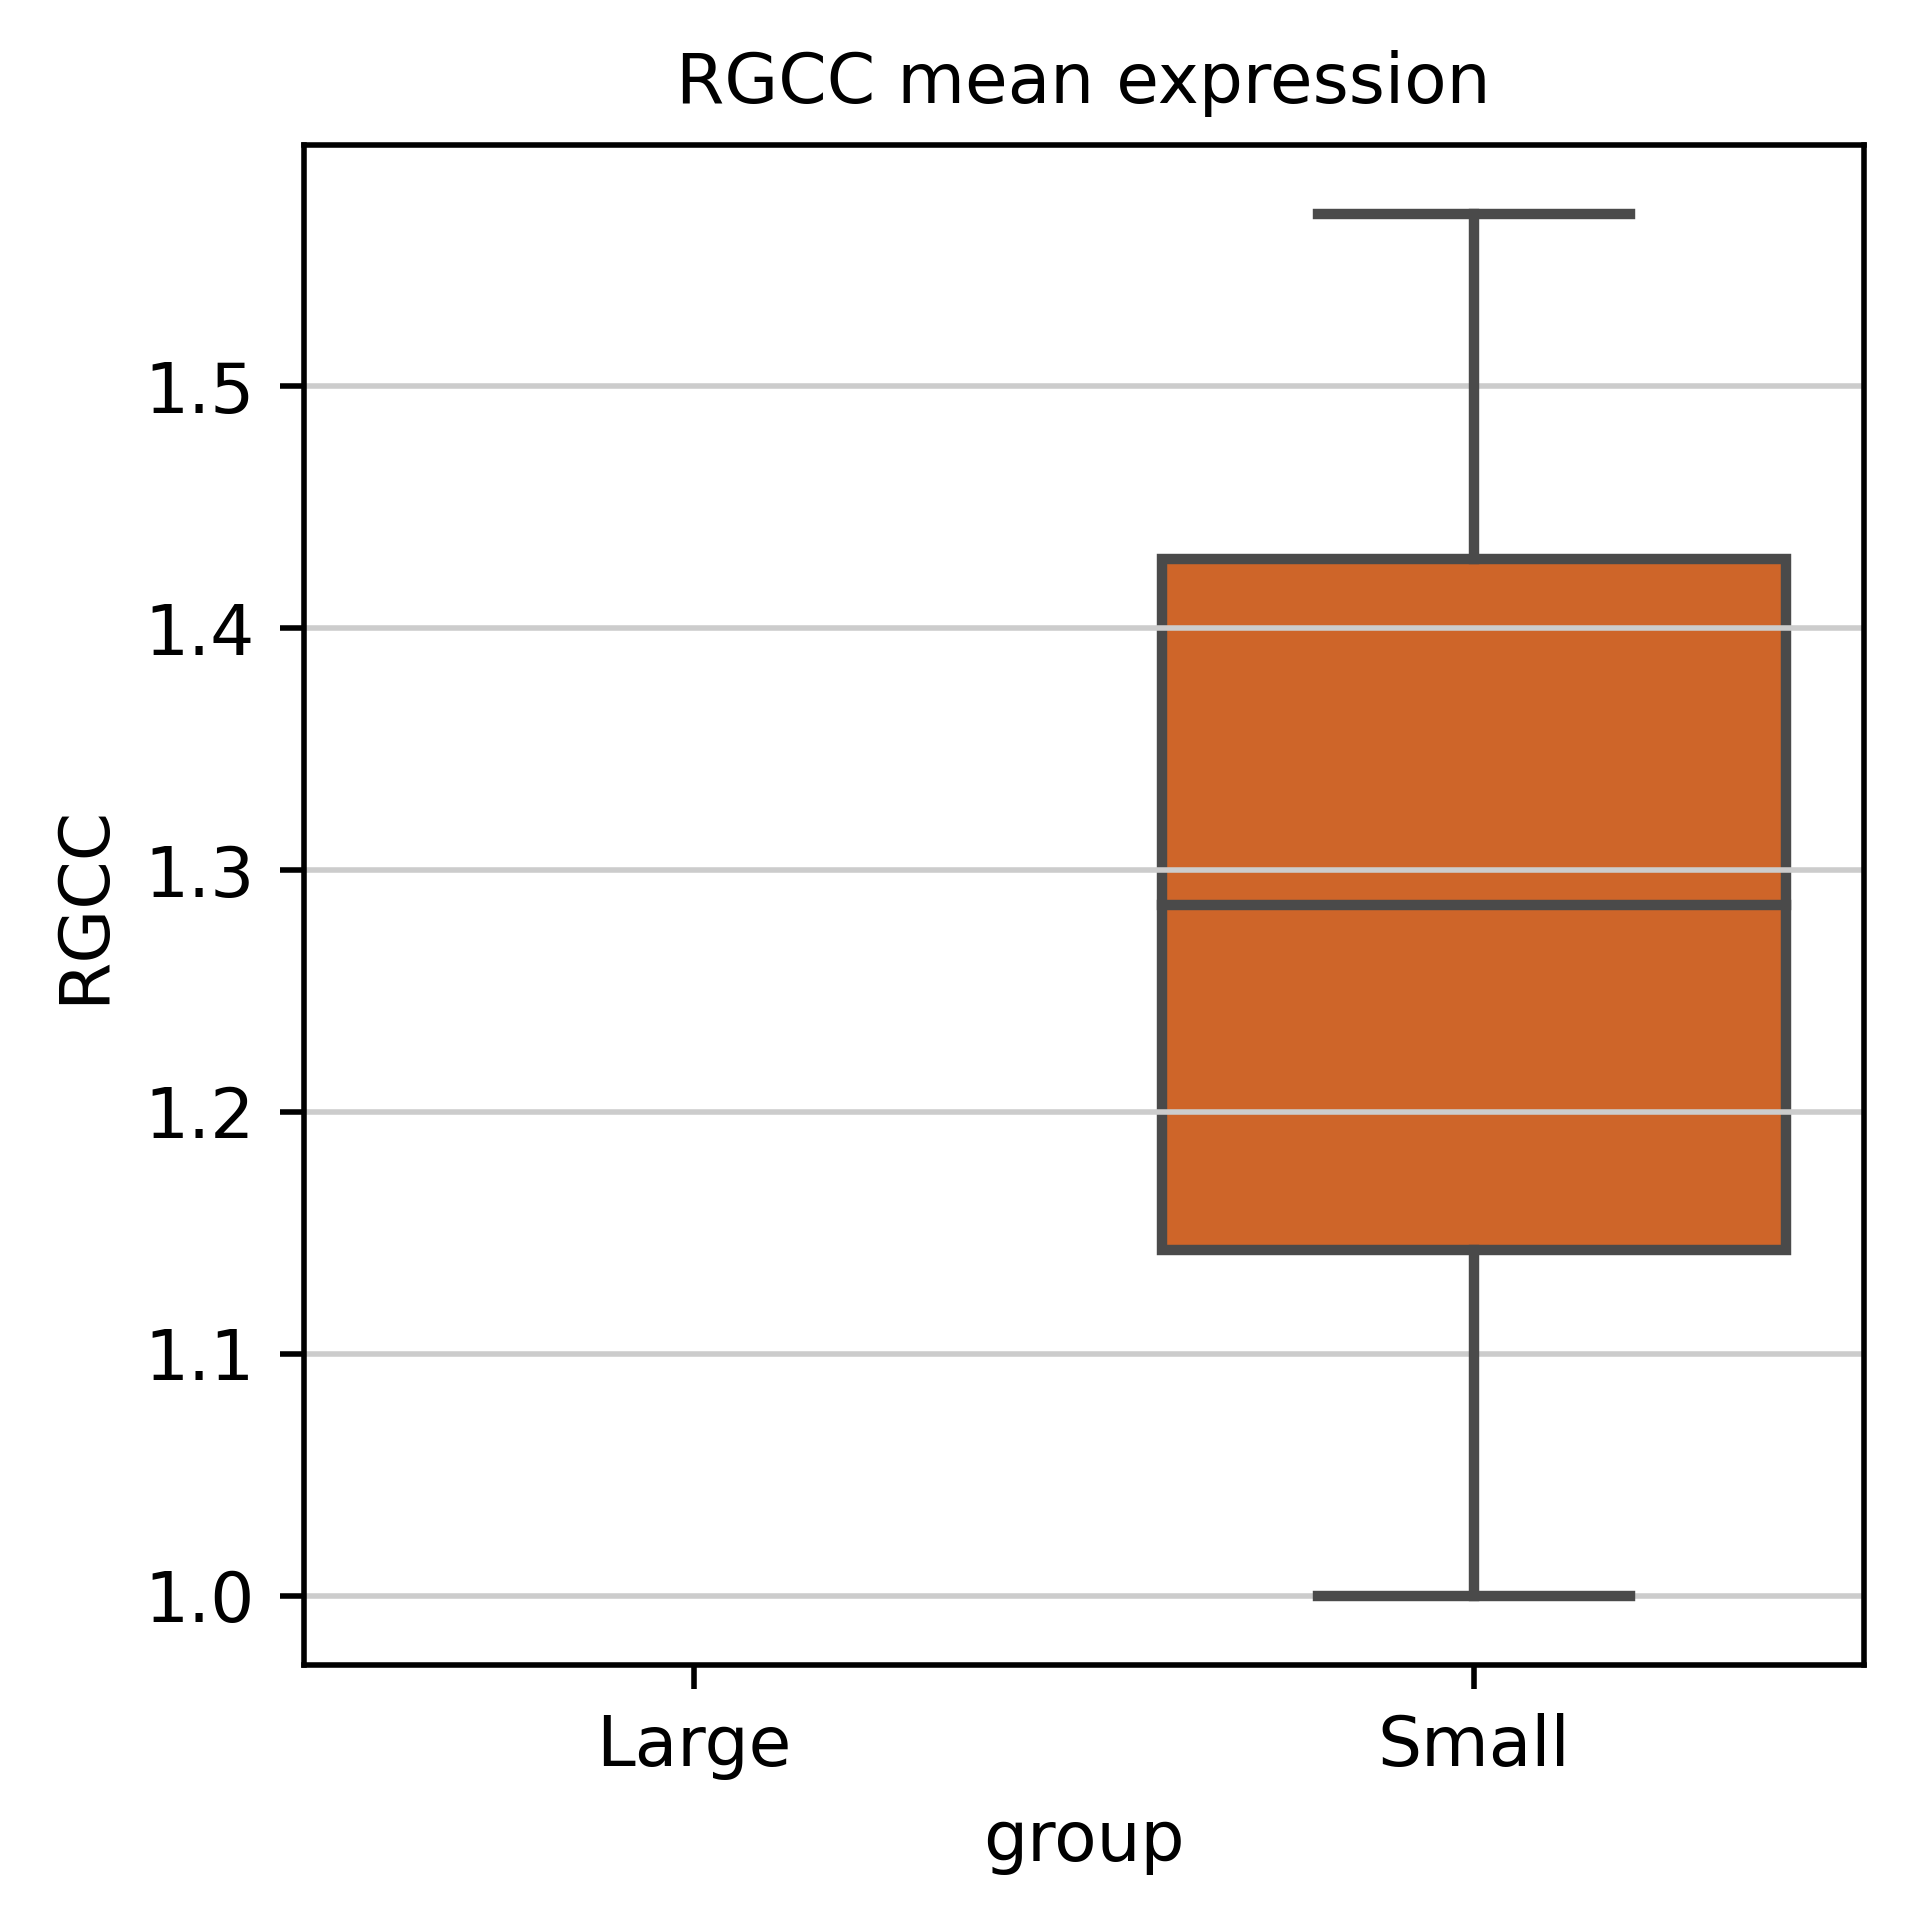

In [106]:
sns.boxplot(data = results2, x = "group", y = "RGCC", palette = 'Oranges', order = ['Large','Small']).set(title='RGCC mean expression')

[Text(0.5, 1.0, 'SEMA3G mean expression')]

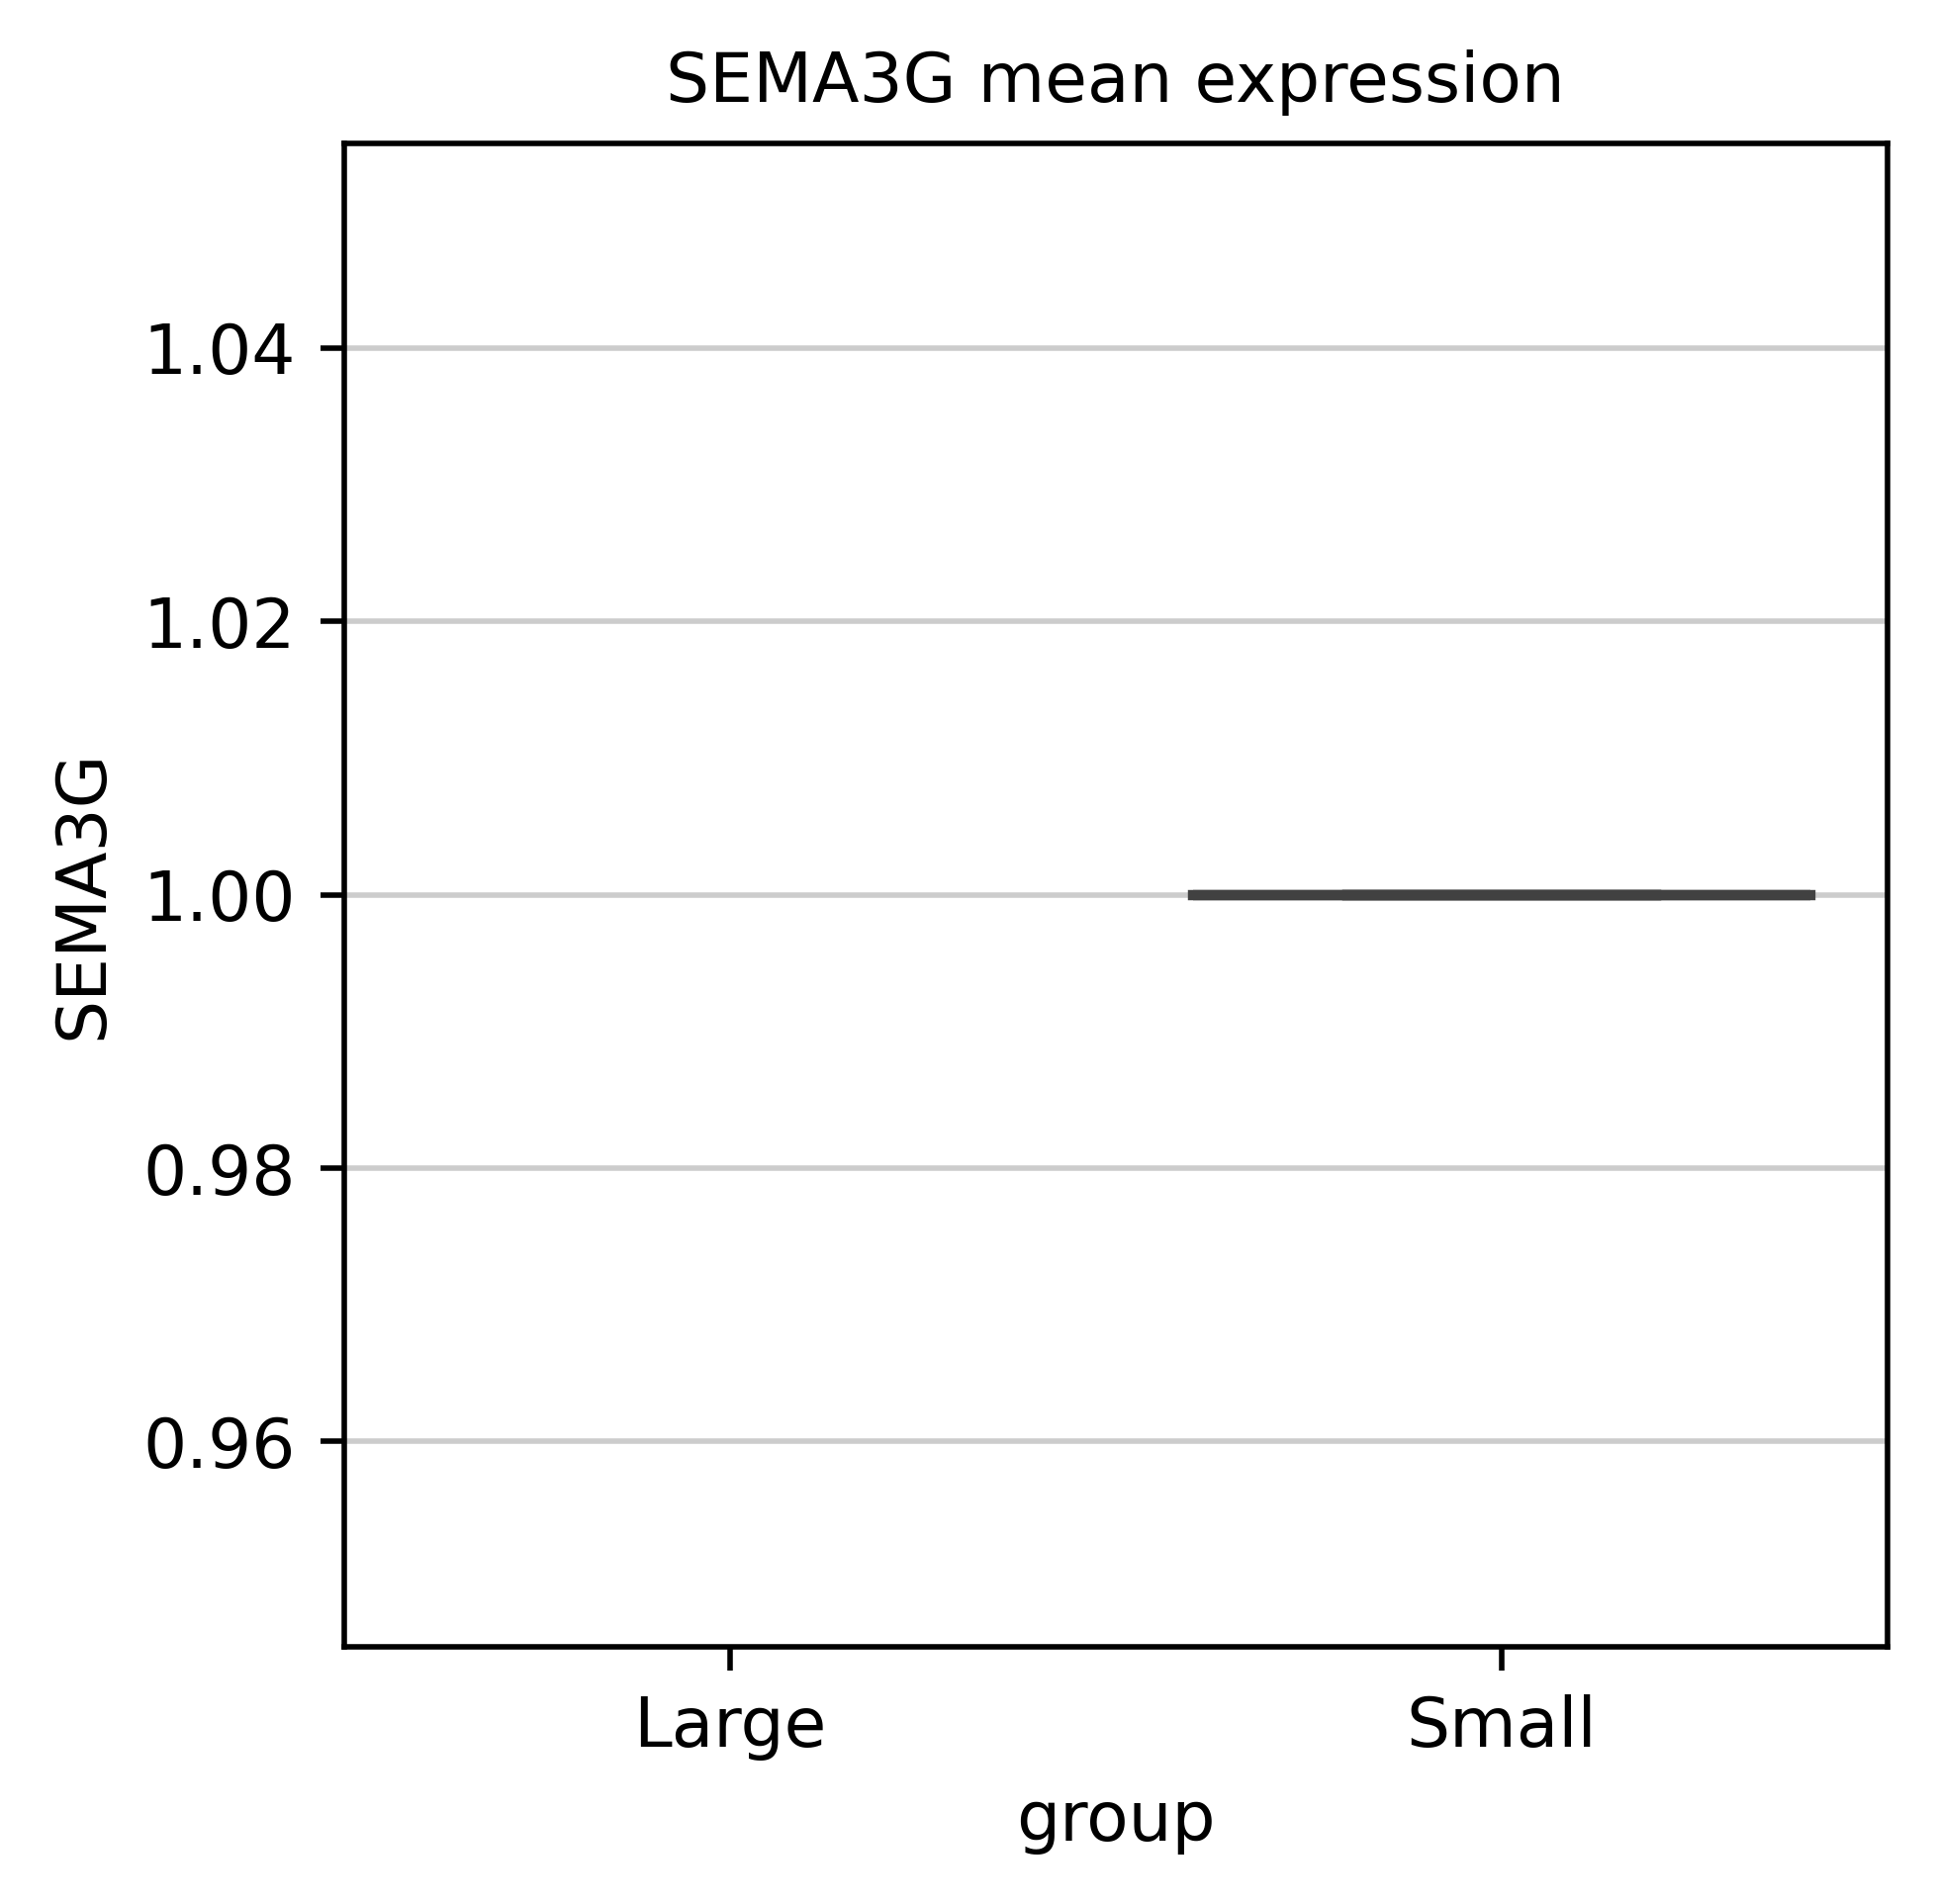

In [107]:
sns.boxplot(data = results2, x = "group", y = "SEMA3G", palette = 'Greens', order = ['Large','Small']).set(title='SEMA3G mean expression')

[Text(0.5, 1.0, 'NEBL mean expression')]

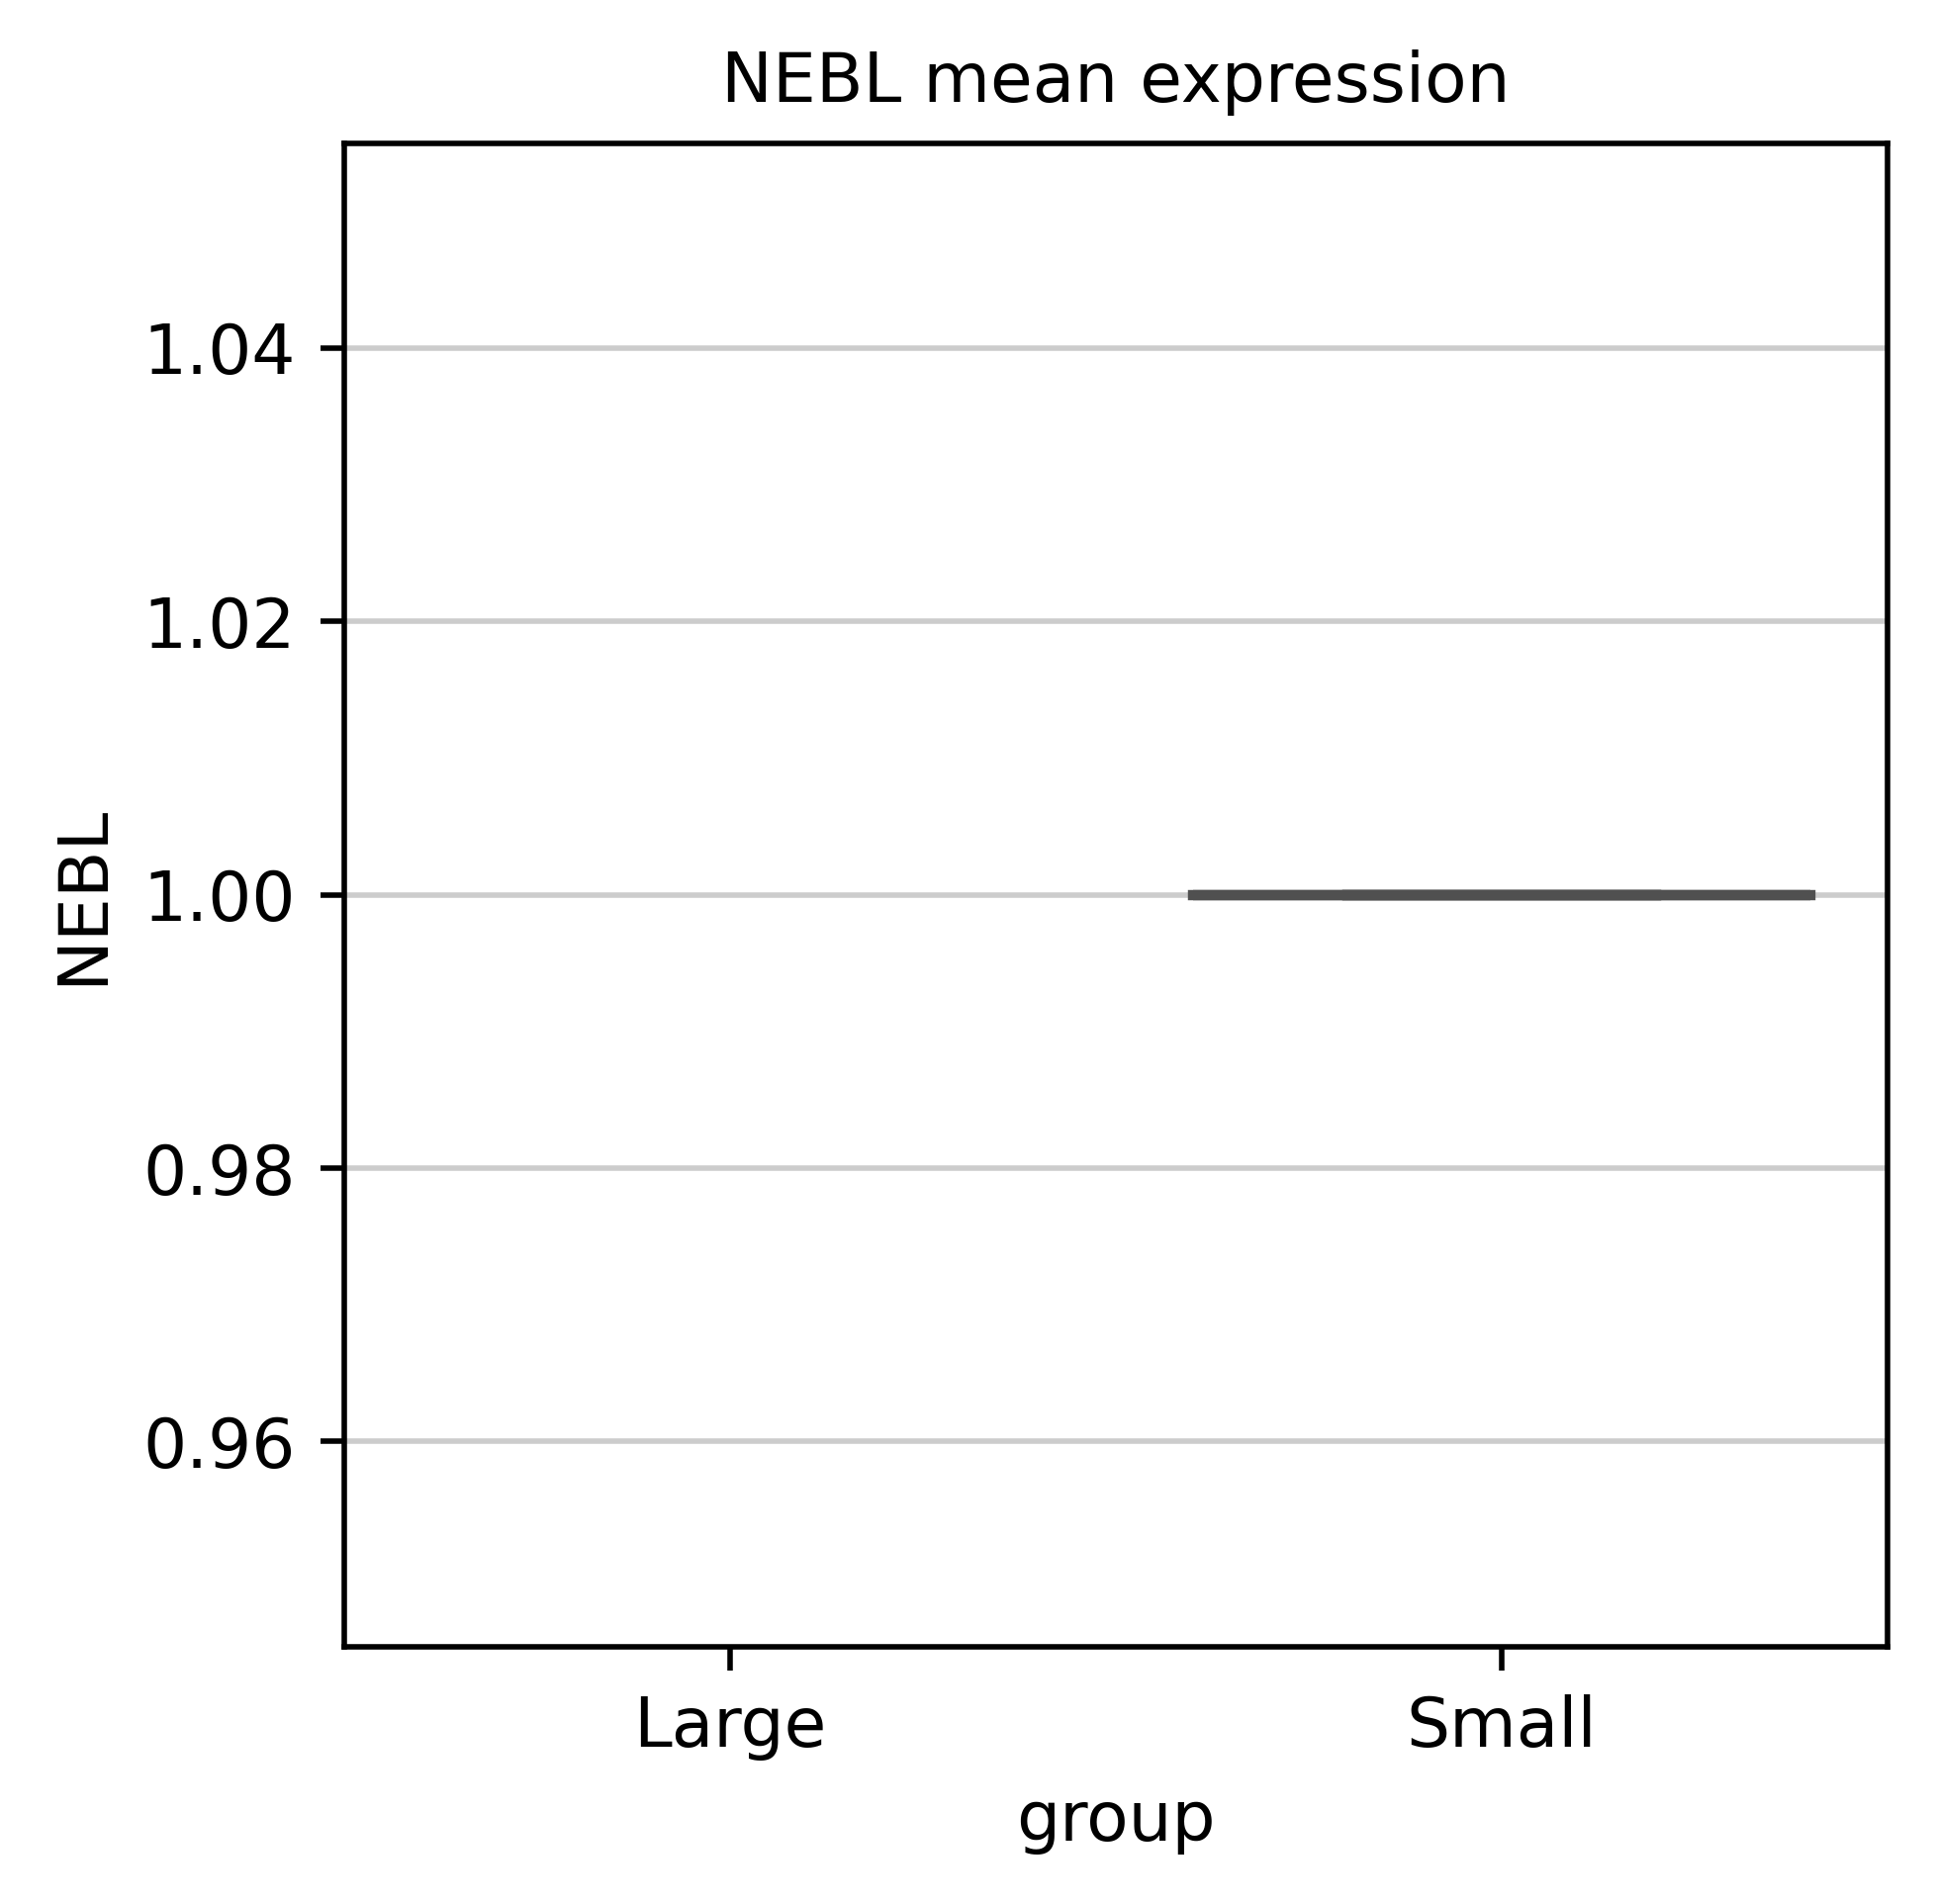

In [108]:
sns.boxplot(data = results2, x = "group", y = "NEBL", palette = 'Reds', order = ['Large','Small']).set(title='NEBL mean expression')

[Text(0.5, 1.0, 'NEBL percent expressing')]

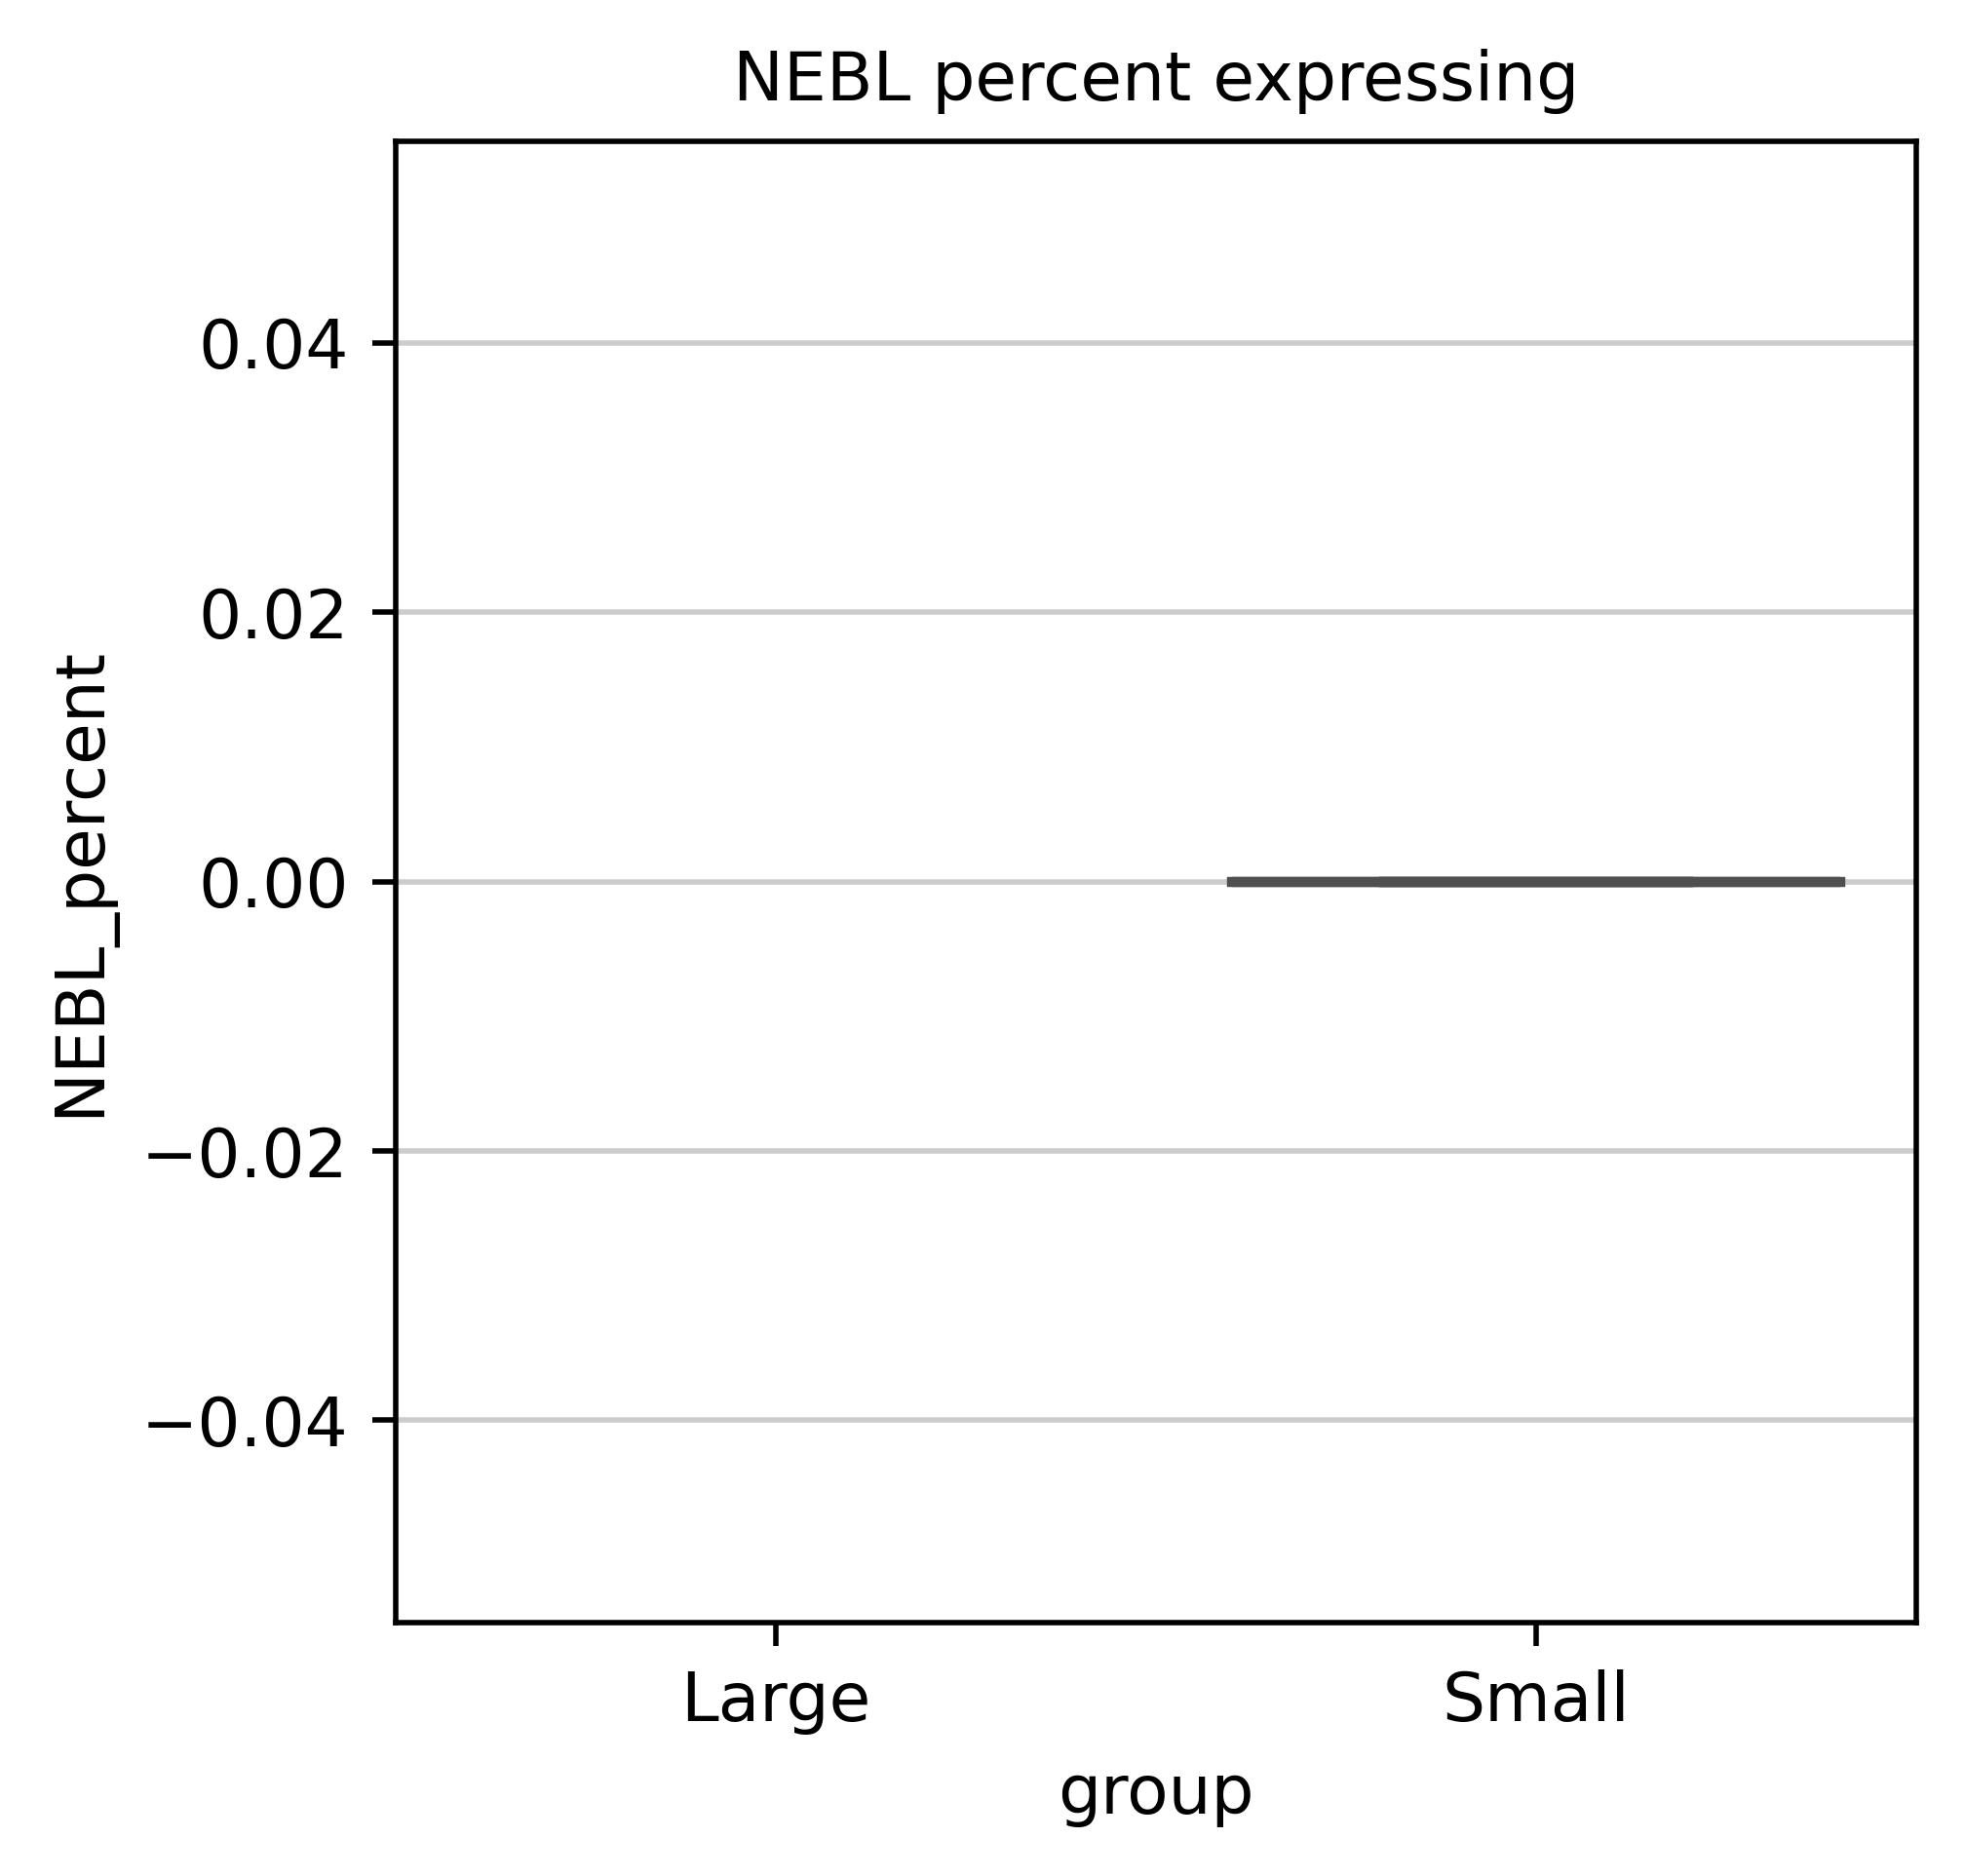

In [109]:
sns.boxplot(data = results2, x = "group", y = "NEBL_percent", palette = 'Reds', order = ['Large','Small']).set(title='NEBL percent expressing')

[Text(0.5, 1.0, 'SULF1+NEBL percent expressing')]

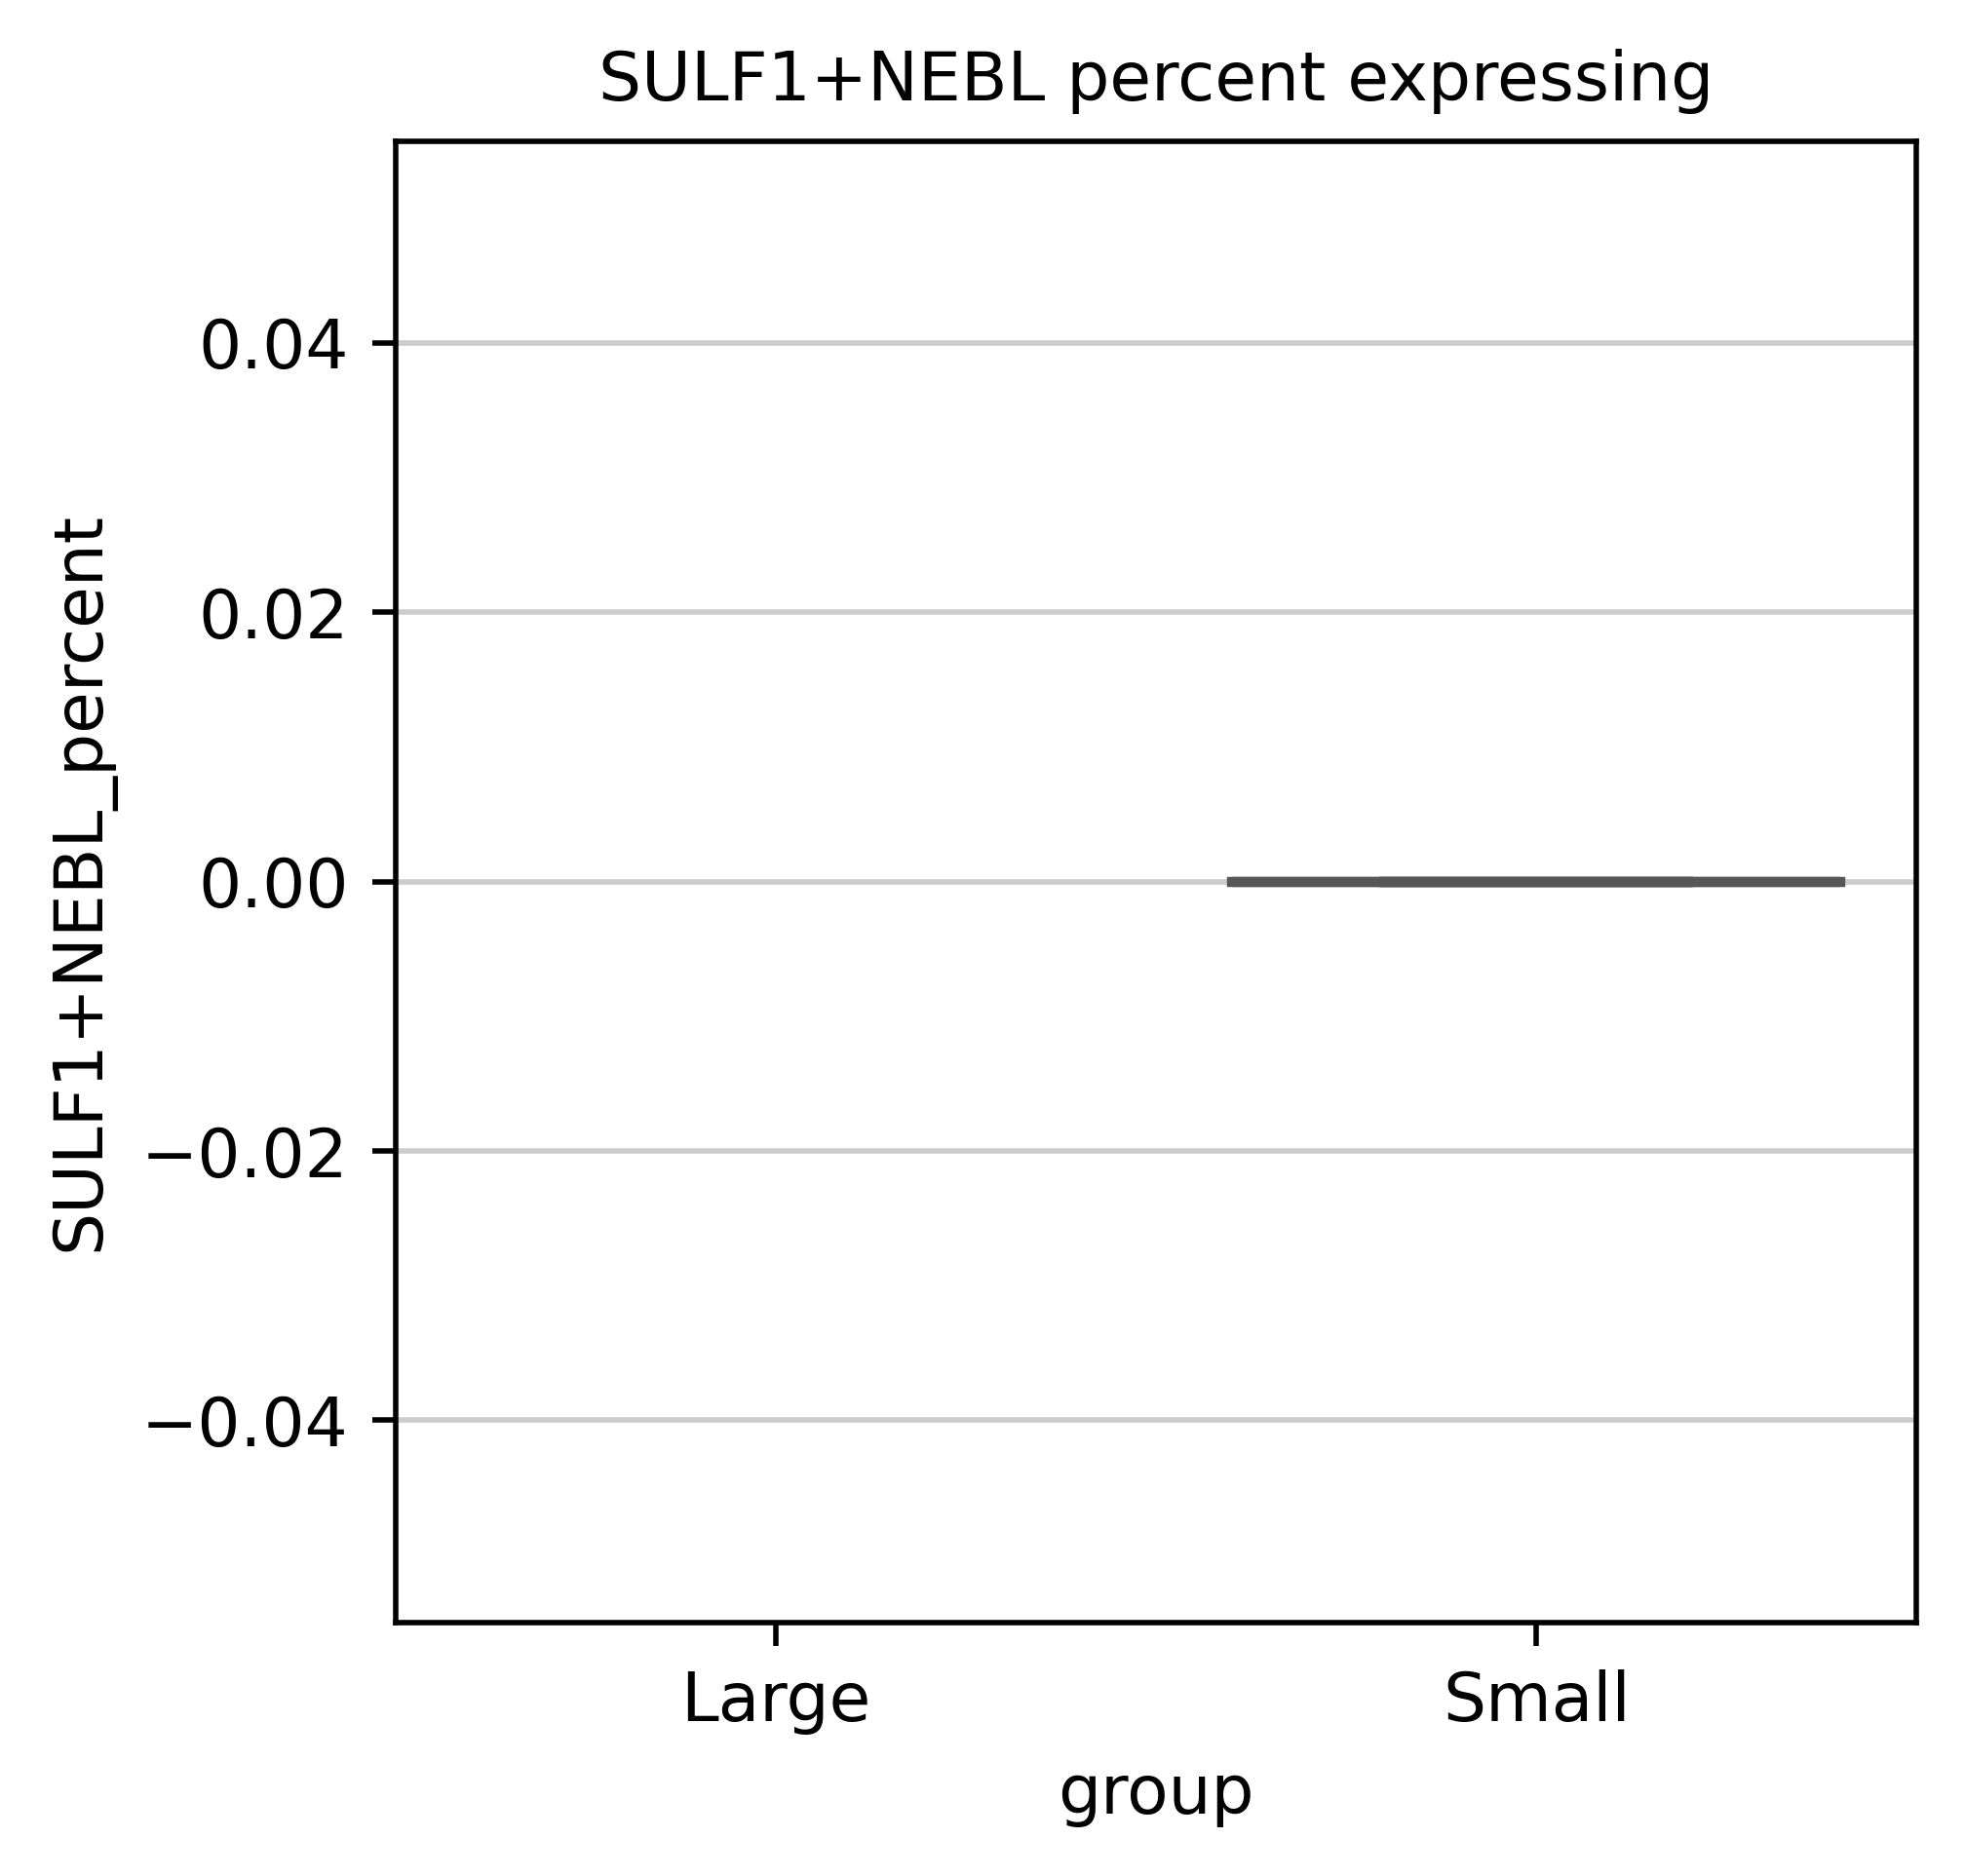

In [110]:
sns.boxplot(data = results2, x = "group", y = "SULF1+NEBL_percent", palette = 'Purples', order = ['Large','Small']).set(title='SULF1+NEBL percent expressing')

In [ ]:
### calculate mean / group

In [ ]:
results3 = results2.groupby("group").mean()

In [ ]:
results3["ROI"] = 'd2-1'

In [ ]:
results3

In [ ]:
markers = ["VWF","GJA5","SEMA3G","SULF1","NEBL","RGCC"]
sc.pl.dotplot(adata_aec_subset, markers, "Artery_clusters", mean_only_expressed = True)
#sc.pl.dotplot(adata_aec_subset, markers, "Artery_clusters", mean_only_expressed = False)

In [ ]:
sc.pl.spatial(adata_aec_subset,color="Artery_clusters",img_key='WGA',size=8, alpha_img = 0.2)